In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 7.7 MB/s 
     |████████████████████████████████| 4.6 MB 5.2 MB/s 
     |████████████████████████████████| 280 kB 6.4 MB/s 


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
from time import perf_counter
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'Guided BP'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [5]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...
Done!


In [6]:
torch.manual_seed(123456)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# **Batching Data by DataLoader**

In [7]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 10

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Model Designing**

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.elu(x)

        x = self.conv2(x, edge_index)
        x = torch.nn.functional.elu(x)

        #x = self.conv3(x, edge_index)
        #x = torch.nn.functional.elu(x)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x


GuidedBP_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
print(GuidedBP_model_GCN)

GCN(
  (conv1): GCNConv(7, 10)
  (conv2): GCNConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)


In [9]:
GuidedBP_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
GuidedBP_model_GCN.eval()

###########################################
non_GuidedBP_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
non_GuidedBP_model_GCN.eval()




GCN(
  (conv1): GCNConv(7, 10)
  (conv2): GCNConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)

In [10]:
GuidedBP_optimizer = torch.optim.Adam(GuidedBP_model_GCN.parameters(), lr=0.001)

In [11]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch


In [12]:
def loading_model(load_index):
  GuidedBP_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
  GuidedBP_optimizer = torch.optim.Adam(params = GuidedBP_model_GCN.parameters(), lr=1e-4)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  GuidedBP_model_GCN.load_state_dict(checkpoint['model_state_dict'])
  GuidedBP_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return GuidedBP_model_GCN, GuidedBP_optimizer, epoch

In [13]:
def visualize_losses(g_losses, epoch_history):
  g_losses_list = torch.stack(g_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("Guided Model Loss in Epoch: " + str(epoch_history))

  ax.plot(g_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  

# **Traning Configurations**

In [14]:
def train_step():
  GuidedBP_loss_batch = []

  GuidedBP_model_GCN.train()
  GuidedBP_optimizer.zero_grad()
  for batched_data in train_loader:
    GuidedBP_out = GuidedBP_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    GuidedBP_loss = loss_calculations(GuidedBP_out, batched_data.y)
    GuidedBP_loss_batch.append(GuidedBP_loss)
    GuidedBP_loss.backward()
    GuidedBP_optimizer.step()
        
    
  GuidedBP_optimizer.step()
  
  #############################################################



  return torch.mean(torch.tensor(GuidedBP_loss_batch))


In [15]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [16]:
#from IPython.display import Javascript  # Restrict height of output cell.
#display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


def train(EPOCHS, load_index):
  GuidedBP_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    GuidedBP_model_training_loss = train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {GuidedBP_model_training_loss:.4f}')

    GuidedBP_training_loss_per_epoch.append(GuidedBP_model_training_loss)
    #break

    if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(GuidedBP_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GuidedBP_model_GCN.state_dict(), 'optimizer_state_dict': GuidedBP_optimizer.state_dict(), 'loss': GuidedBP_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss





# **Test Configuration for the Model**

In [17]:
def GuidedBP_test(test_loader):
  GuidedBP_model_GCN.eval()
  correct = 0
  for batched_data in test_loader:  
    GuidedBP_test_out = GuidedBP_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)  
    GuidedBP_test_pred = GuidedBP_test_out.argmax(dim=1)  
    correct += int((GuidedBP_test_pred == batched_data.y).sum())  
  return correct / len(test_loader.dataset)  

<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-18-d17a5d269471>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if load_index is not 0:


Epoch: 001, Guided BP Model Loss: 0.6776
Epoch: 002, Guided BP Model Loss: 0.6750
Epoch: 003, Guided BP Model Loss: 0.6721
Epoch: 004, Guided BP Model Loss: 0.6703
Epoch: 005, Guided BP Model Loss: 0.6627
Epoch: 006, Guided BP Model Loss: 0.6541
Epoch: 007, Guided BP Model Loss: 0.6574
Epoch: 008, Guided BP Model Loss: 0.6516
Epoch: 009, Guided BP Model Loss: 0.6489
Epoch: 010, Guided BP Model Loss: 0.6518
Epoch: 011, Guided BP Model Loss: 0.6386
Epoch: 012, Guided BP Model Loss: 0.6465
Epoch: 013, Guided BP Model Loss: 0.6294
Epoch: 014, Guided BP Model Loss: 0.6334
Epoch: 015, Guided BP Model Loss: 0.6338
Epoch: 016, Guided BP Model Loss: 0.6417
Epoch: 017, Guided BP Model Loss: 0.6589
Epoch: 018, Guided BP Model Loss: 0.6314
Epoch: 019, Guided BP Model Loss: 0.6235
Epoch: 020, Guided BP Model Loss: 0.6152
Epoch: 021, Guided BP Model Loss: 0.6424
Epoch: 022, Guided BP Model Loss: 0.6398
Epoch: 023, Guided BP Model Loss: 0.6462
Epoch: 024, Guided BP Model Loss: 0.6362
Epoch: 025, Guid

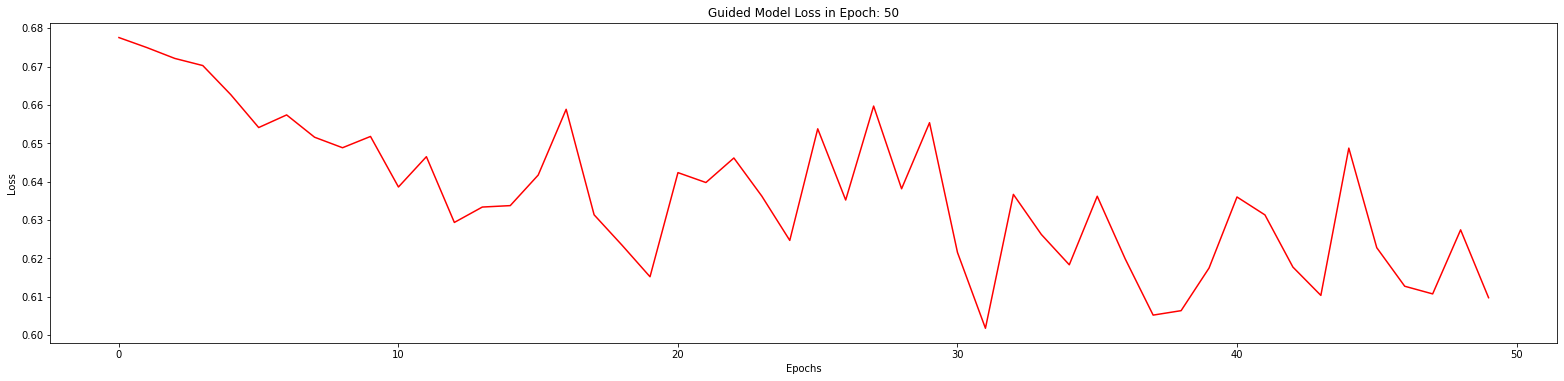

Epoch: 051, Guided BP Model Loss: 0.5999
Epoch: 052, Guided BP Model Loss: 0.6012
Epoch: 053, Guided BP Model Loss: 0.6115
Epoch: 054, Guided BP Model Loss: 0.6009
Epoch: 055, Guided BP Model Loss: 0.6346
Epoch: 056, Guided BP Model Loss: 0.5773
Epoch: 057, Guided BP Model Loss: 0.6367
Epoch: 058, Guided BP Model Loss: 0.5930
Epoch: 059, Guided BP Model Loss: 0.6028
Epoch: 060, Guided BP Model Loss: 0.5947
Epoch: 061, Guided BP Model Loss: 0.6143
Epoch: 062, Guided BP Model Loss: 0.6232
Epoch: 063, Guided BP Model Loss: 0.6000
Epoch: 064, Guided BP Model Loss: 0.6024
Epoch: 065, Guided BP Model Loss: 0.6105
Epoch: 066, Guided BP Model Loss: 0.5947
Epoch: 067, Guided BP Model Loss: 0.6052
Epoch: 068, Guided BP Model Loss: 0.5728
Epoch: 069, Guided BP Model Loss: 0.6050
Epoch: 070, Guided BP Model Loss: 0.5847
Epoch: 071, Guided BP Model Loss: 0.5995
Epoch: 072, Guided BP Model Loss: 0.5893
Epoch: 073, Guided BP Model Loss: 0.5612
Epoch: 074, Guided BP Model Loss: 0.6053
Epoch: 075, Guid

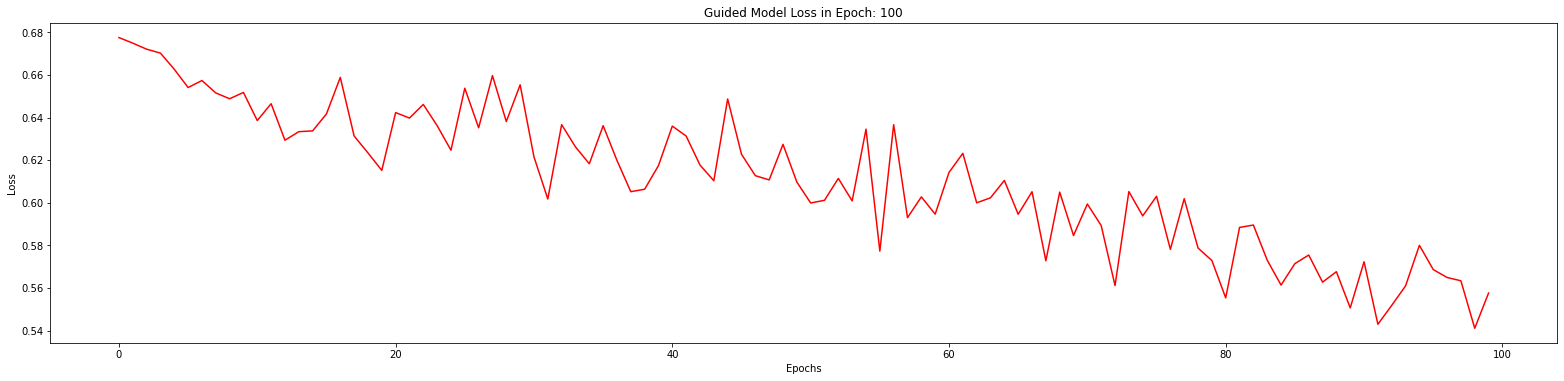

Epoch: 101, Guided BP Model Loss: 0.5759
Epoch: 102, Guided BP Model Loss: 0.5372
Epoch: 103, Guided BP Model Loss: 0.5473
Epoch: 104, Guided BP Model Loss: 0.5642
Epoch: 105, Guided BP Model Loss: 0.5788
Epoch: 106, Guided BP Model Loss: 0.5675
Epoch: 107, Guided BP Model Loss: 0.5742
Epoch: 108, Guided BP Model Loss: 0.6083
Epoch: 109, Guided BP Model Loss: 0.5852
Epoch: 110, Guided BP Model Loss: 0.5775
Epoch: 111, Guided BP Model Loss: 0.5779
Epoch: 112, Guided BP Model Loss: 0.5617
Epoch: 113, Guided BP Model Loss: 0.5355
Epoch: 114, Guided BP Model Loss: 0.5669
Epoch: 115, Guided BP Model Loss: 0.5552
Epoch: 116, Guided BP Model Loss: 0.5588
Epoch: 117, Guided BP Model Loss: 0.5418
Epoch: 118, Guided BP Model Loss: 0.5620
Epoch: 119, Guided BP Model Loss: 0.5511
Epoch: 120, Guided BP Model Loss: 0.5800
Epoch: 121, Guided BP Model Loss: 0.5655
Epoch: 122, Guided BP Model Loss: 0.5948
Epoch: 123, Guided BP Model Loss: 0.5464
Epoch: 124, Guided BP Model Loss: 0.5420
Epoch: 125, Guid

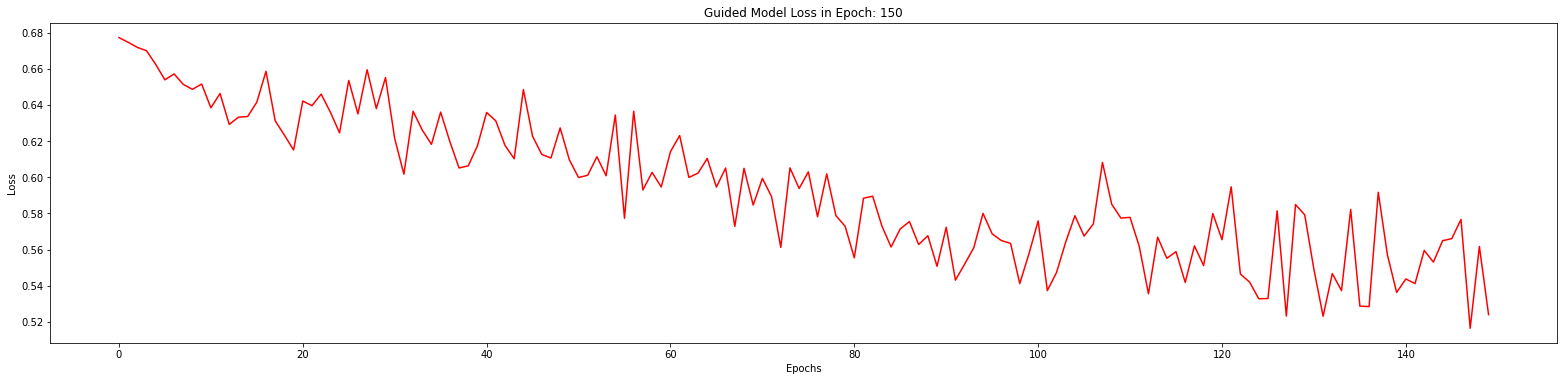

Epoch: 151, Guided BP Model Loss: 0.5818
Epoch: 152, Guided BP Model Loss: 0.5317
Epoch: 153, Guided BP Model Loss: 0.5707
Epoch: 154, Guided BP Model Loss: 0.5751
Epoch: 155, Guided BP Model Loss: 0.5324
Epoch: 156, Guided BP Model Loss: 0.5596
Epoch: 157, Guided BP Model Loss: 0.5503
Epoch: 158, Guided BP Model Loss: 0.5650
Epoch: 159, Guided BP Model Loss: 0.5624
Epoch: 160, Guided BP Model Loss: 0.5541
Epoch: 161, Guided BP Model Loss: 0.5717
Epoch: 162, Guided BP Model Loss: 0.5379
Epoch: 163, Guided BP Model Loss: 0.5619
Epoch: 164, Guided BP Model Loss: 0.5425
Epoch: 165, Guided BP Model Loss: 0.5705
Epoch: 166, Guided BP Model Loss: 0.5898
Epoch: 167, Guided BP Model Loss: 0.5433
Epoch: 168, Guided BP Model Loss: 0.5705
Epoch: 169, Guided BP Model Loss: 0.5841
Epoch: 170, Guided BP Model Loss: 0.5209
Epoch: 171, Guided BP Model Loss: 0.5662
Epoch: 172, Guided BP Model Loss: 0.5395
Epoch: 173, Guided BP Model Loss: 0.5486
Epoch: 174, Guided BP Model Loss: 0.5461
Epoch: 175, Guid

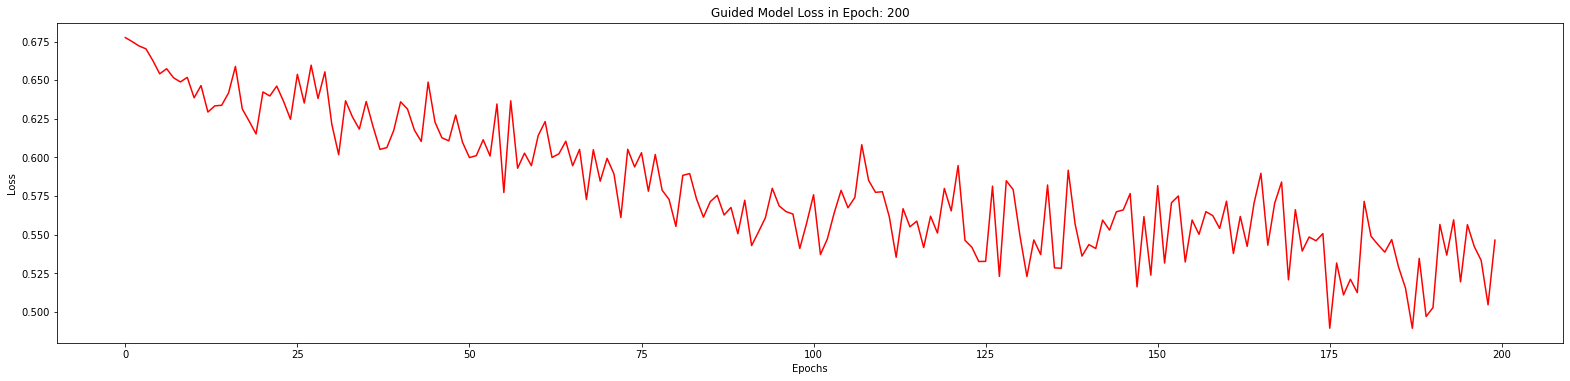

In [18]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

In [19]:
GuidedBP_test_acc = GuidedBP_test(test_loader)
print(f'Test Accuracy: {GuidedBP_test_acc:.4f}')

Test Accuracy: 0.7368


# **Gradients of GuidedBP**


In [ ]:
def accumulate_gradients(model_for_you):
  before_guidance = []
  after_guidance = []
  
  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())

    if name == "conv2.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())

    if name == "conv3.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "conv3.lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())

    if name == "lin.bias":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
    if name == "lin.weight":
      before_guidance.append(param.grad.detach().clone())
      param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
      after_guidance.append(param.grad.detach().clone())
  

  return before_guidance, after_guidance

In [ ]:
holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(GuidedBP_model_GCN)

# **GuidedBP**
# **Based on the LAST Epoch(and also the last Batch), for each Hidden Node in the Hidden Layers, which Gradient(/dimension) is more important?**

In [ ]:
def guided_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, epoch): 
  layer = 1
  for i in range(len(holder_of_new_gradients[layer])):
    fig1 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Guided Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer][i], color='r')
    ax2.plot(holder_of_old_gradients[layer][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()
  
  layer = 2
  for i in range(len(holder_of_new_gradients[layer+1])):
    fig2 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Guided Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+1][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+1][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()
  
  layer = 3
  for i in range(len(holder_of_new_gradients[layer+2])):
    fig3 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Guided Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+2][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+2][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()

  layer = 4
  for i in range(len(holder_of_new_gradients[layer+3])):
    fig4 = plt.figure(figsize=(40,20))

    ax = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Guided Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))
    
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel("Gradients' Value")
    plt.title("Normal Model's Gradients in Layer: " + str(layer) + " Node: " + str(i+1))

    ax.plot(holder_of_new_gradients[layer+3][i], color='r')
    ax2.plot(holder_of_old_gradients[layer+3][i], color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + "Gradients_of_Layer " + str(layer) + " Node " + str(i+1) + "_epoch_{:04d}.png".format(epoch))
    plt.show()

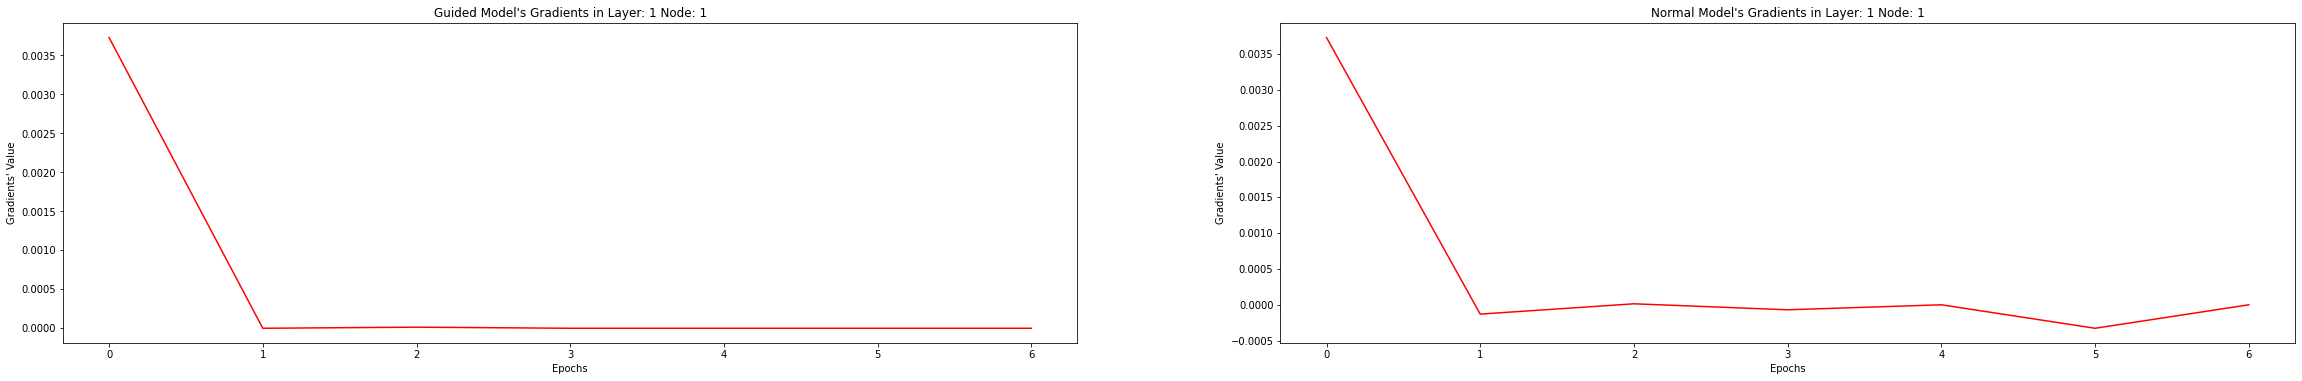

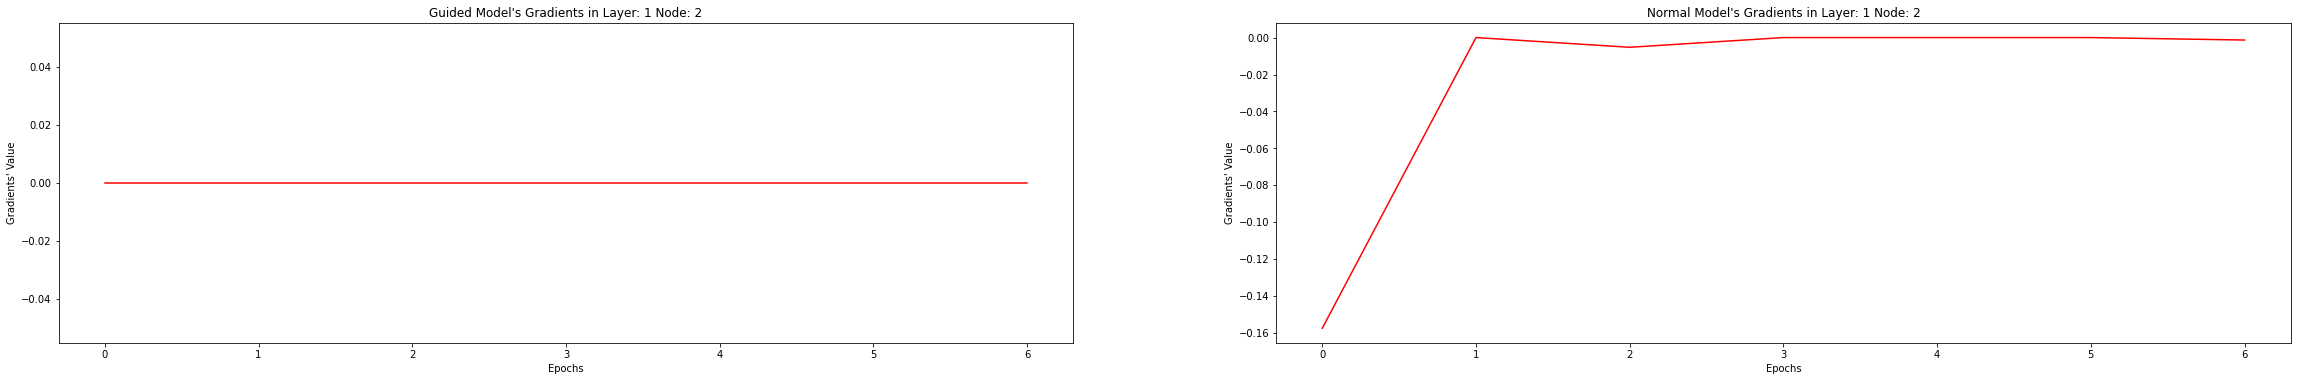

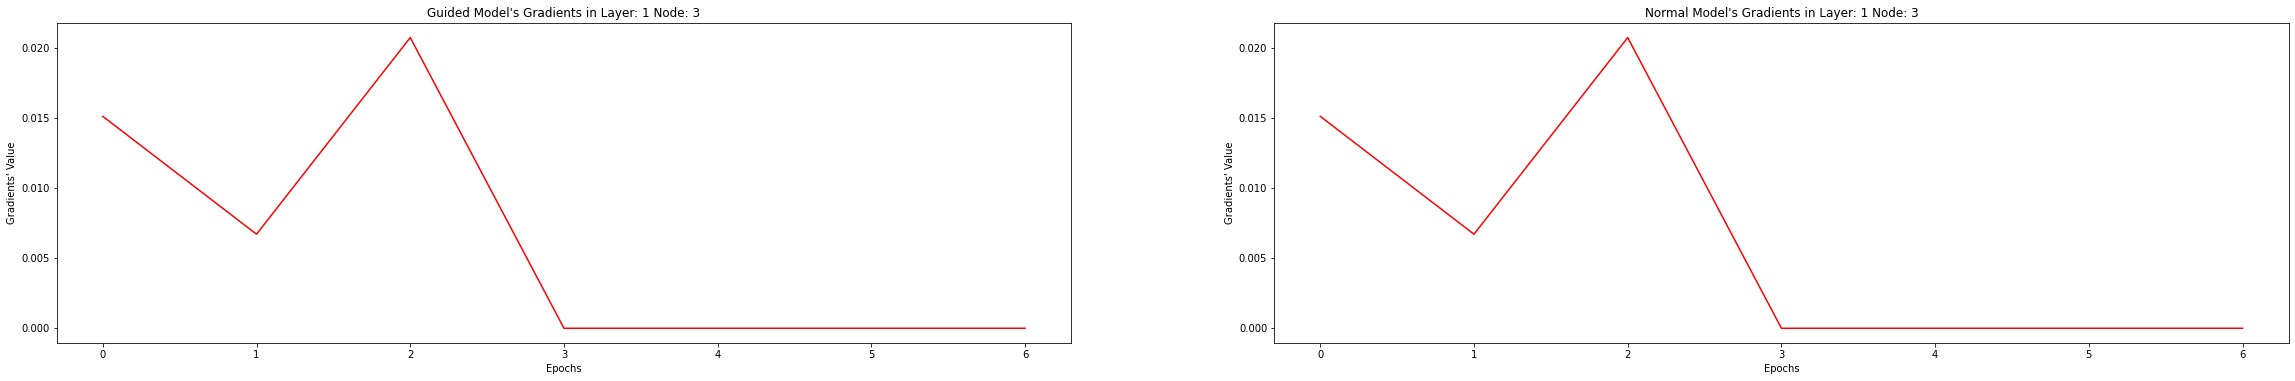

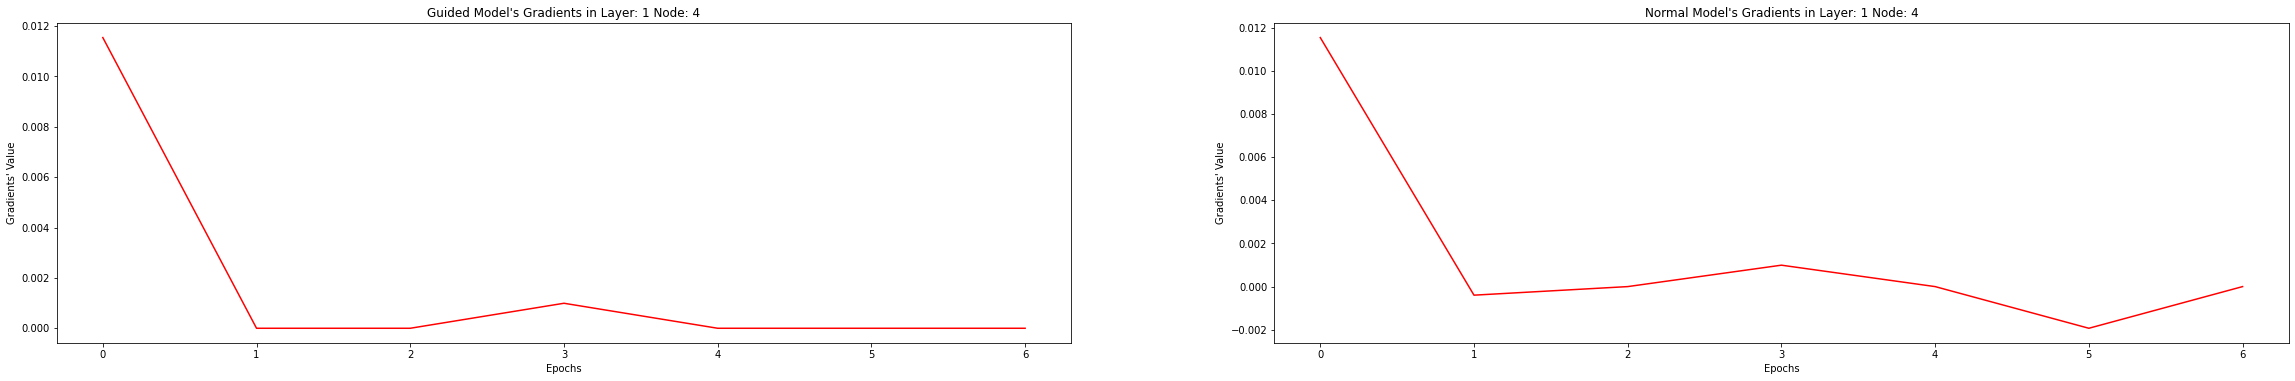

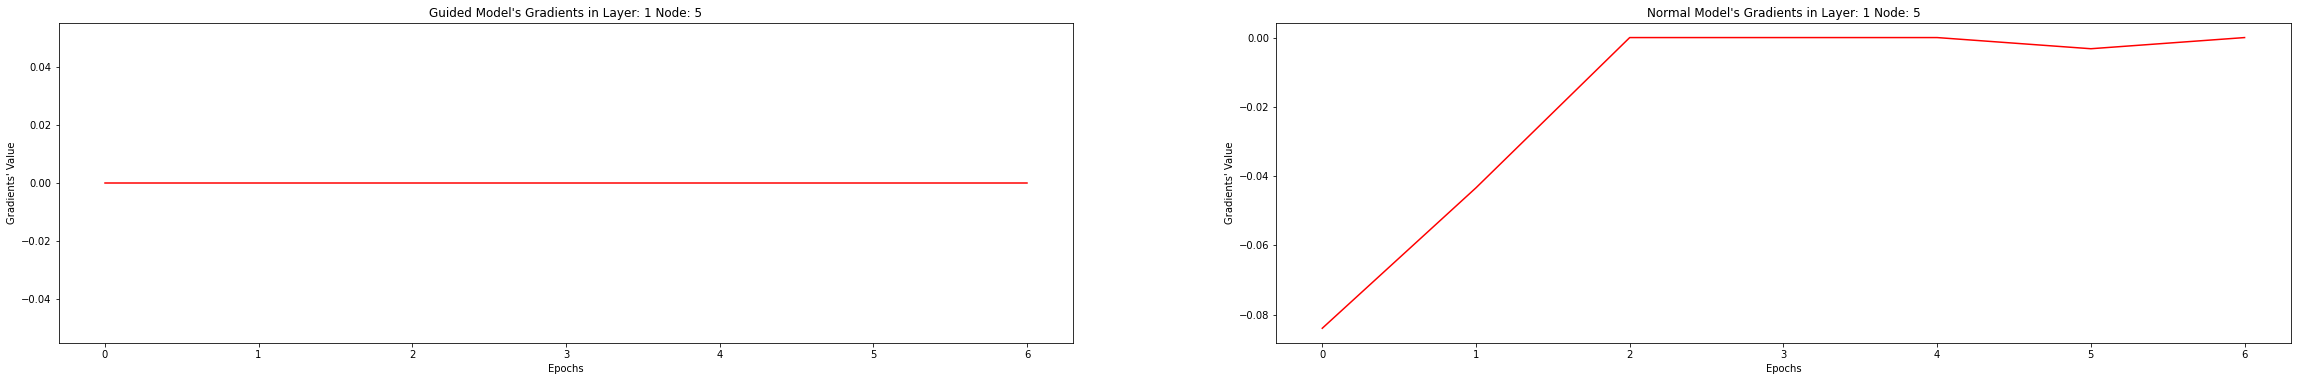

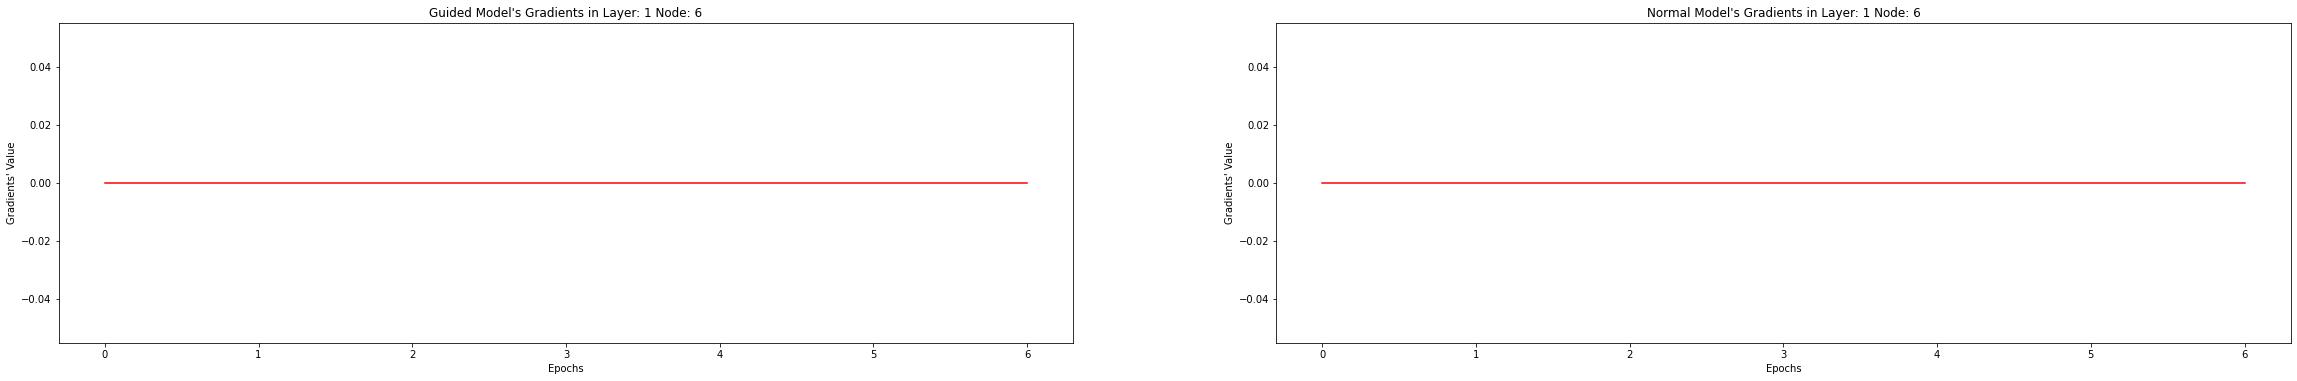

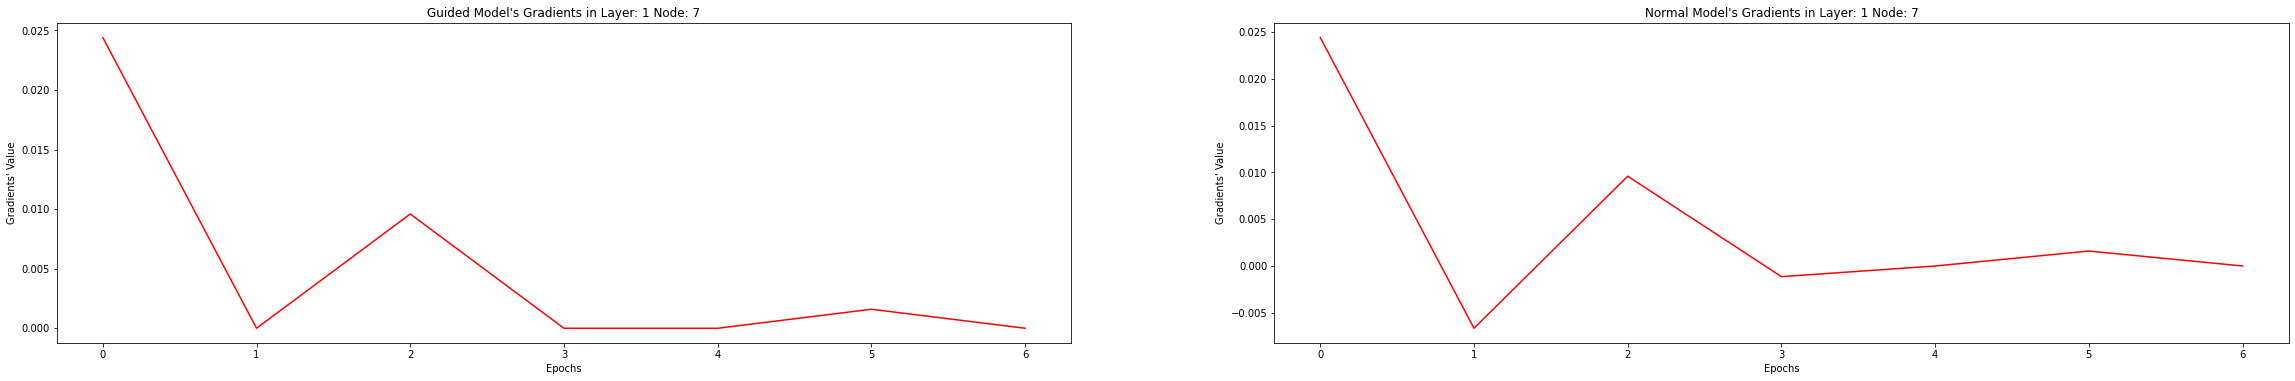

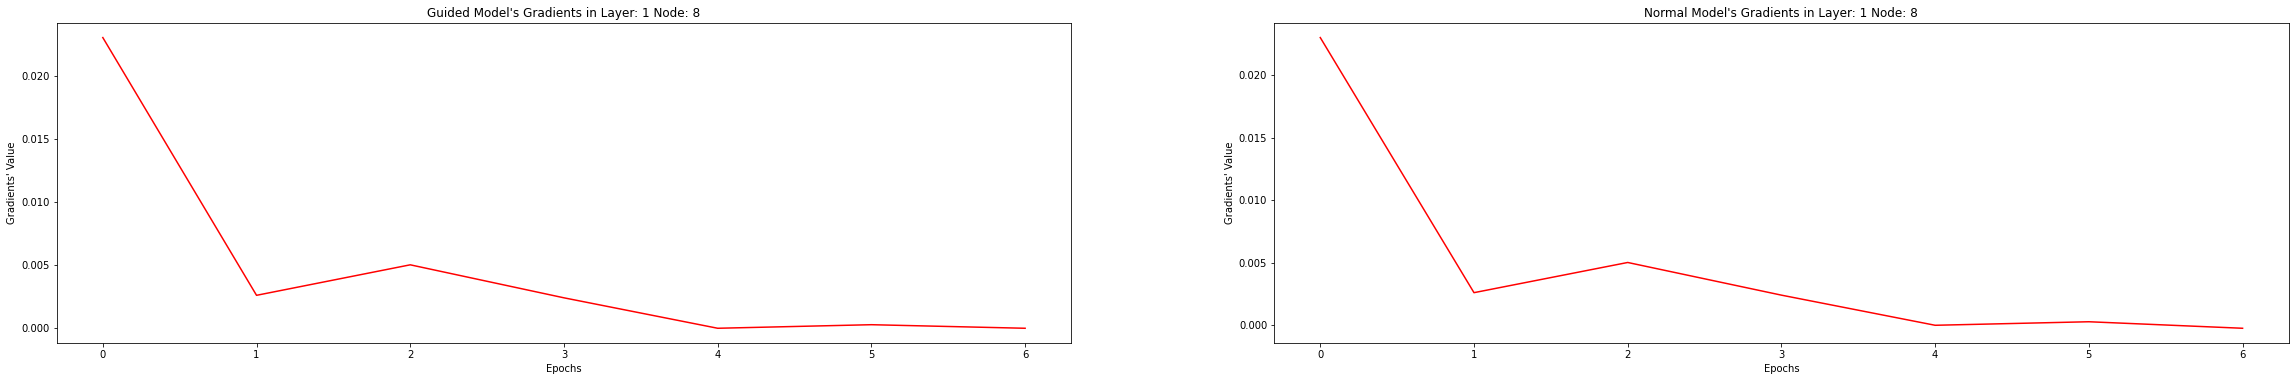

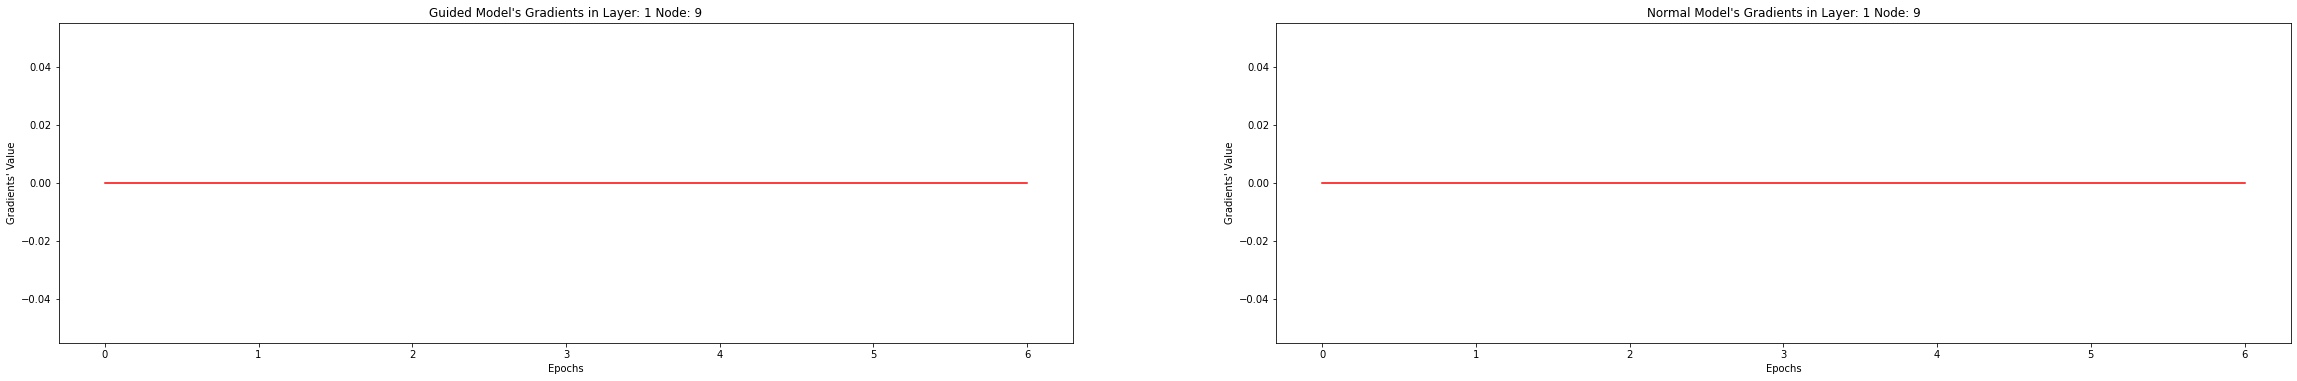

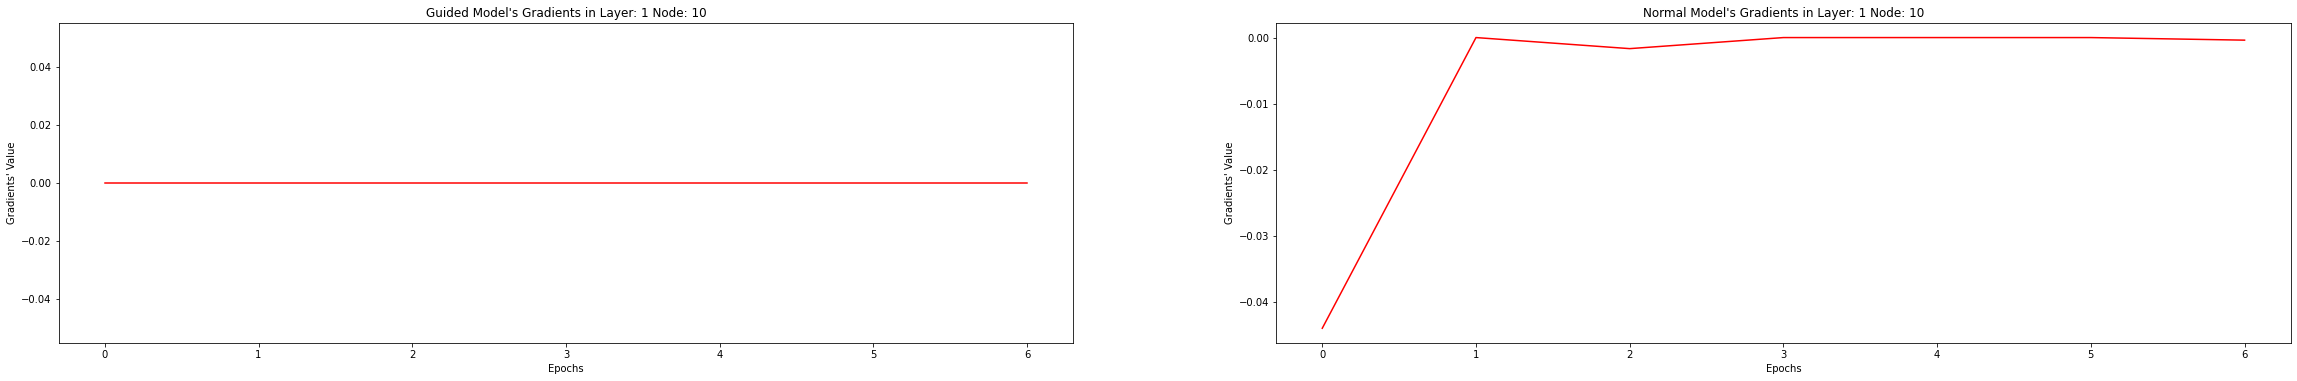

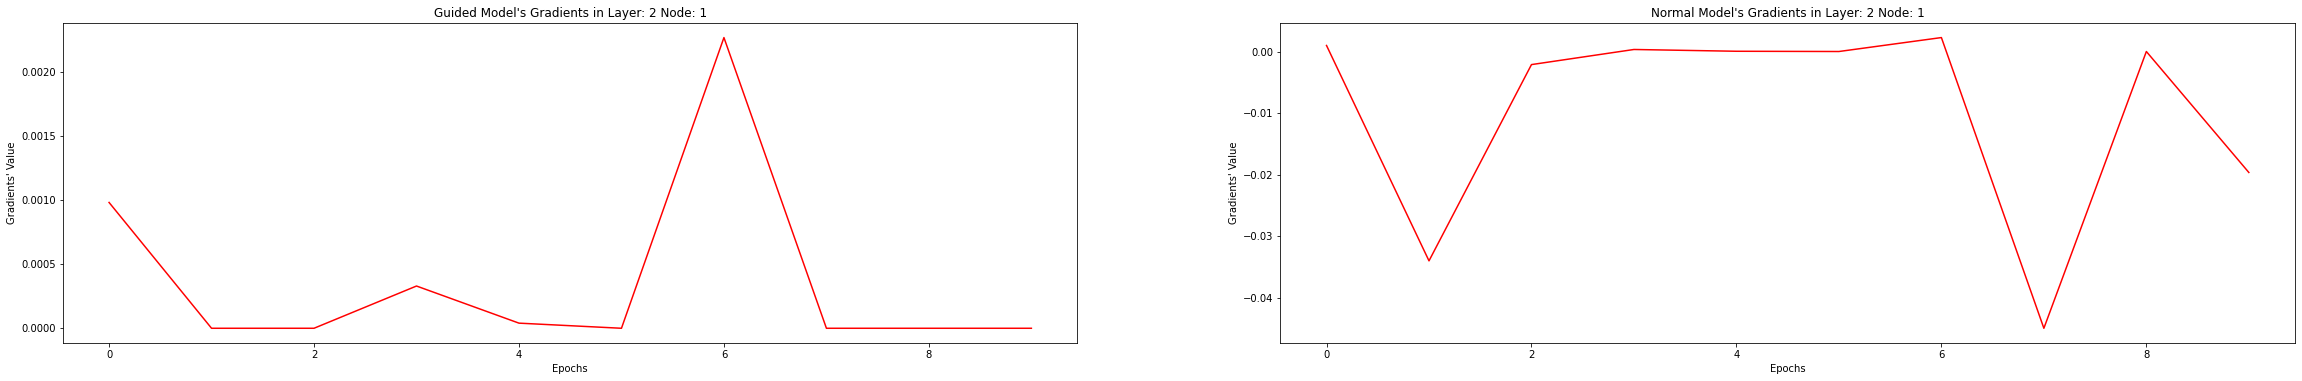

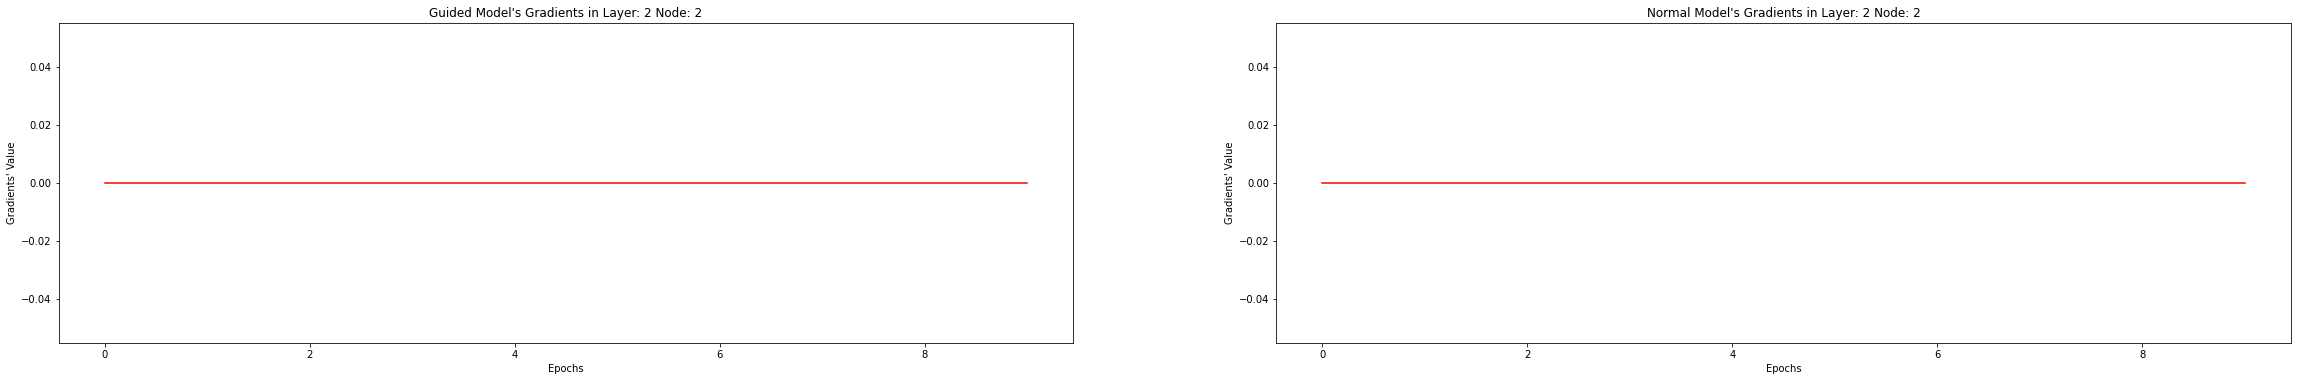

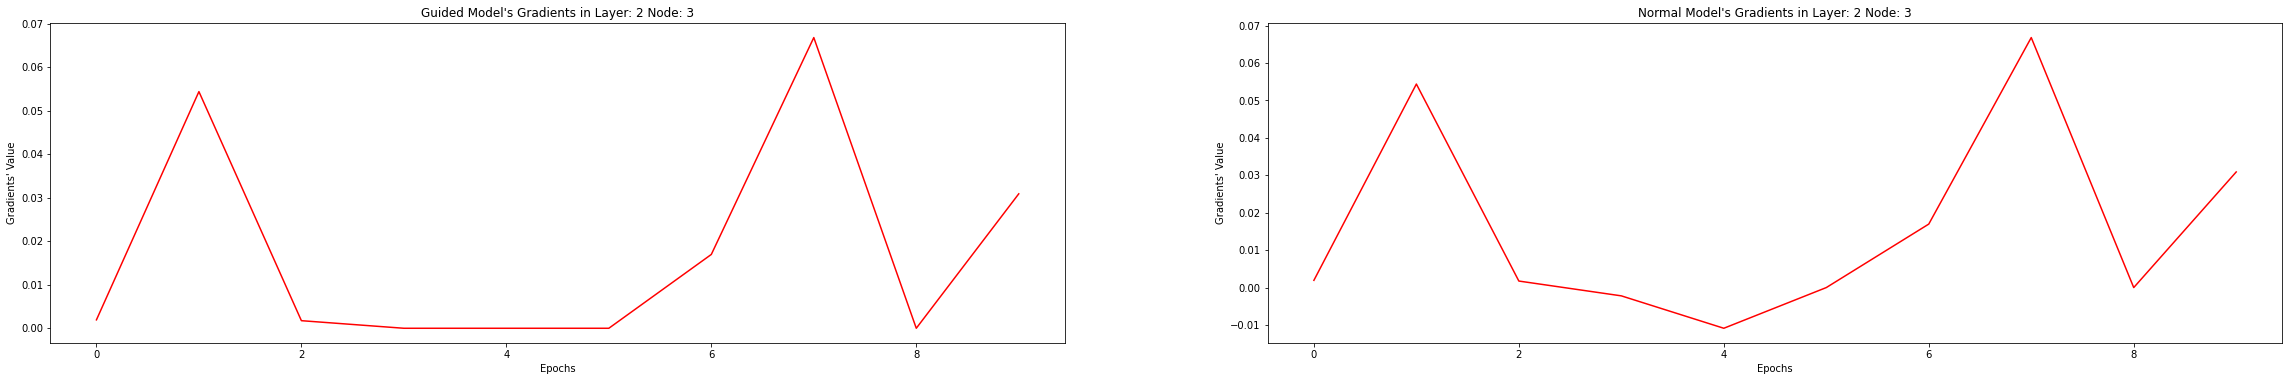

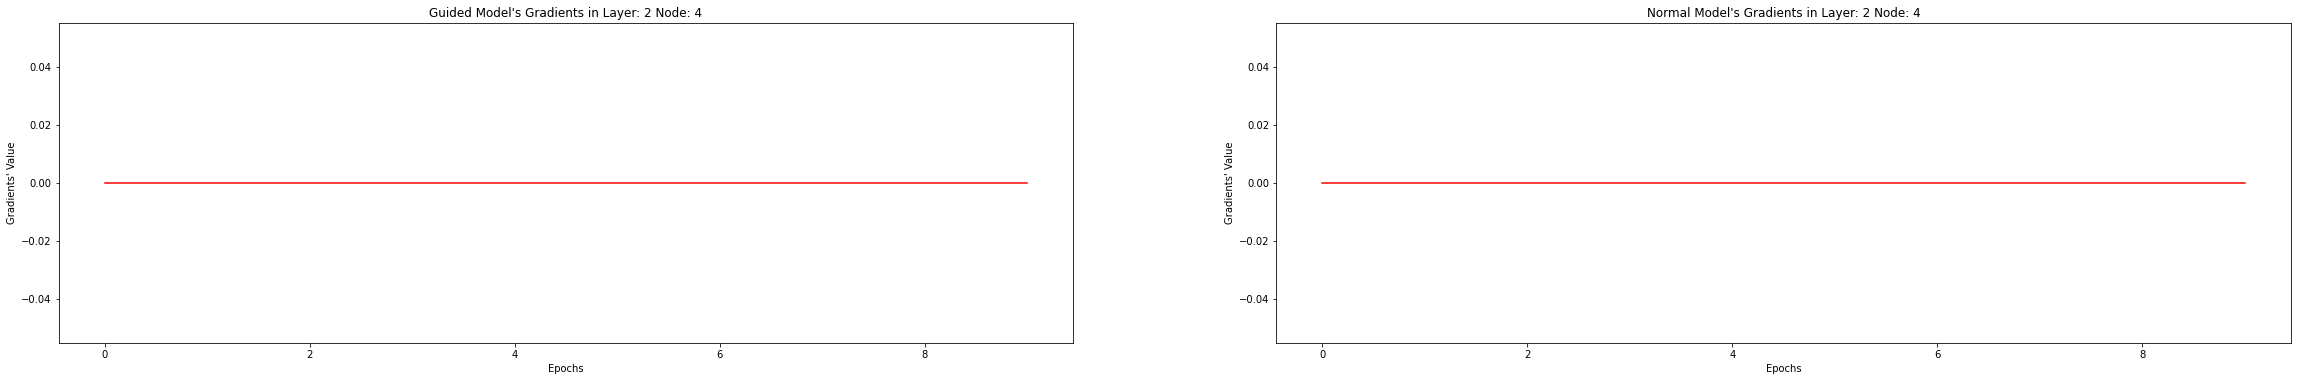

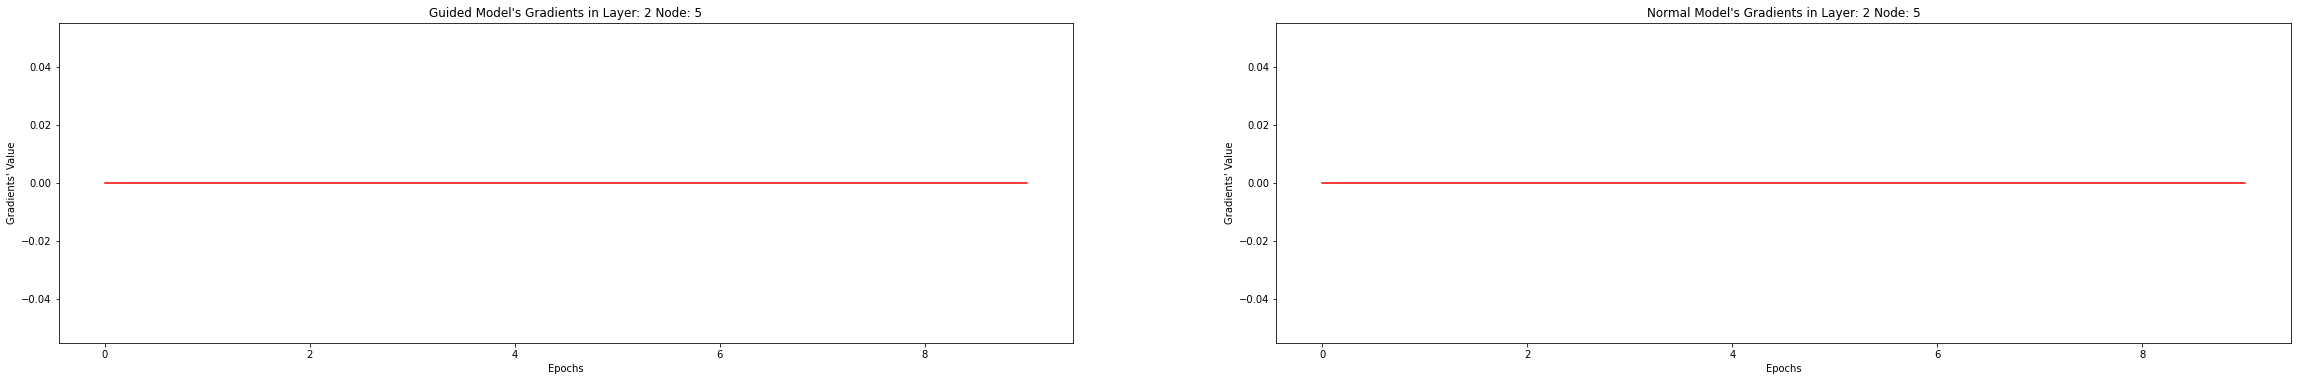

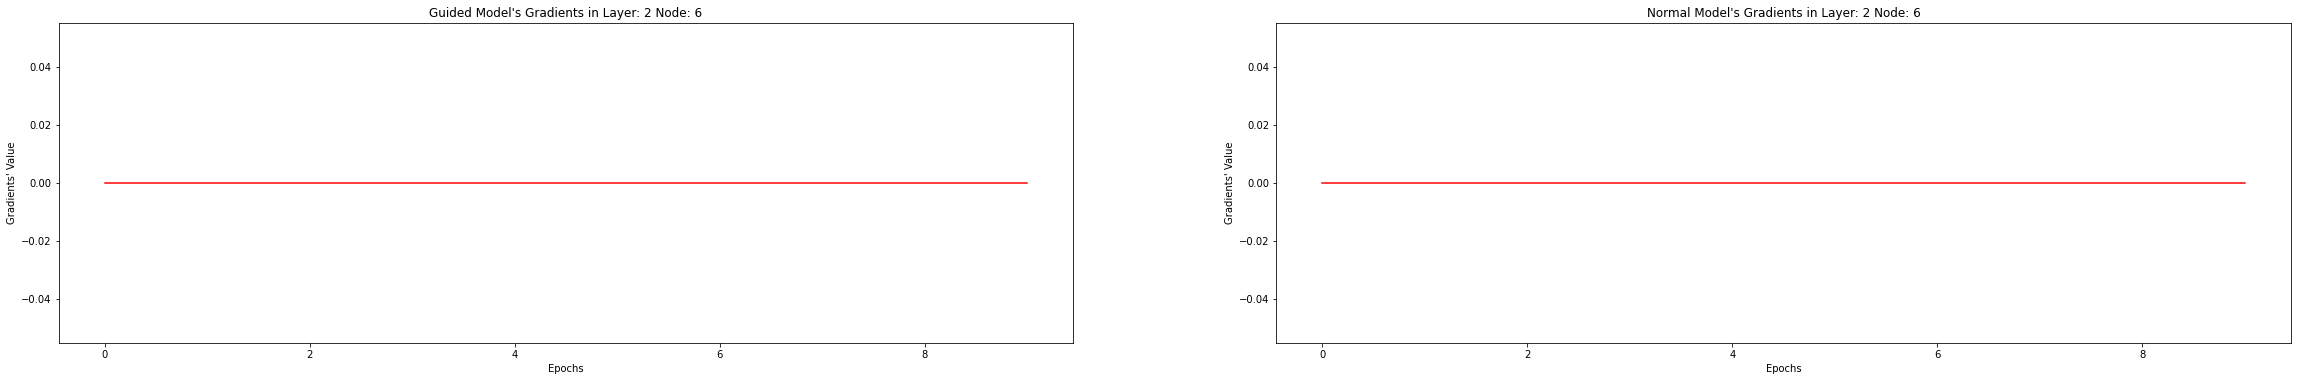

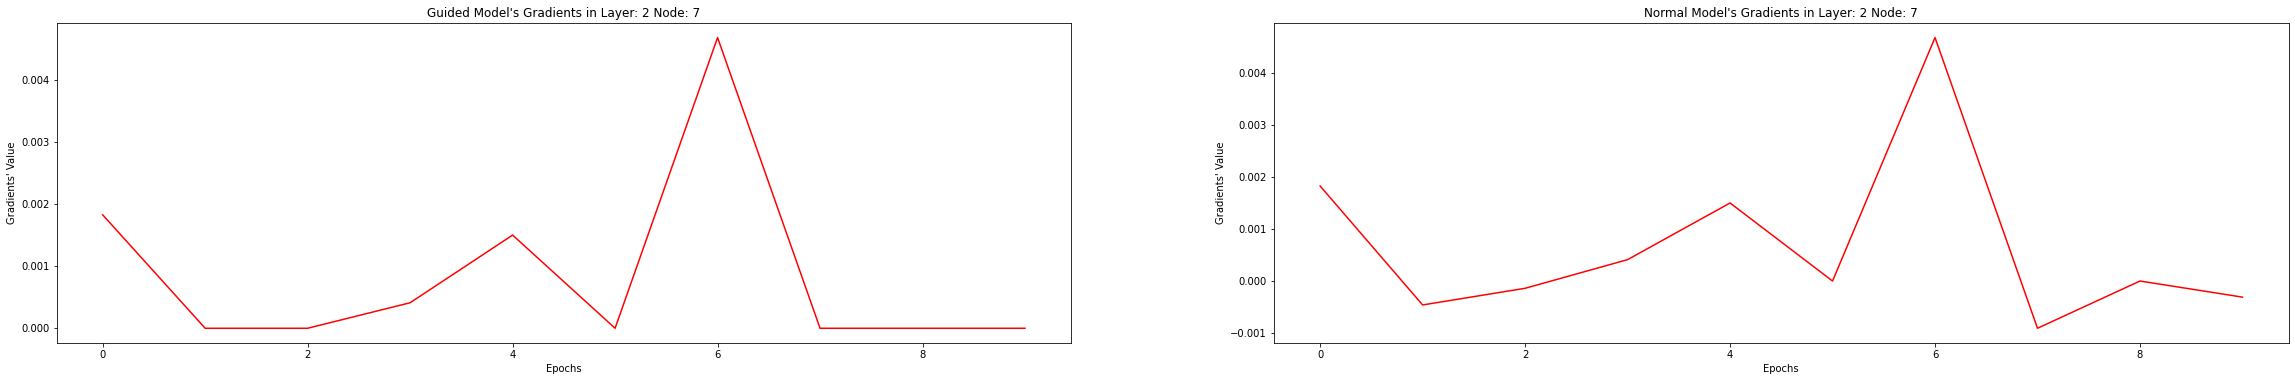

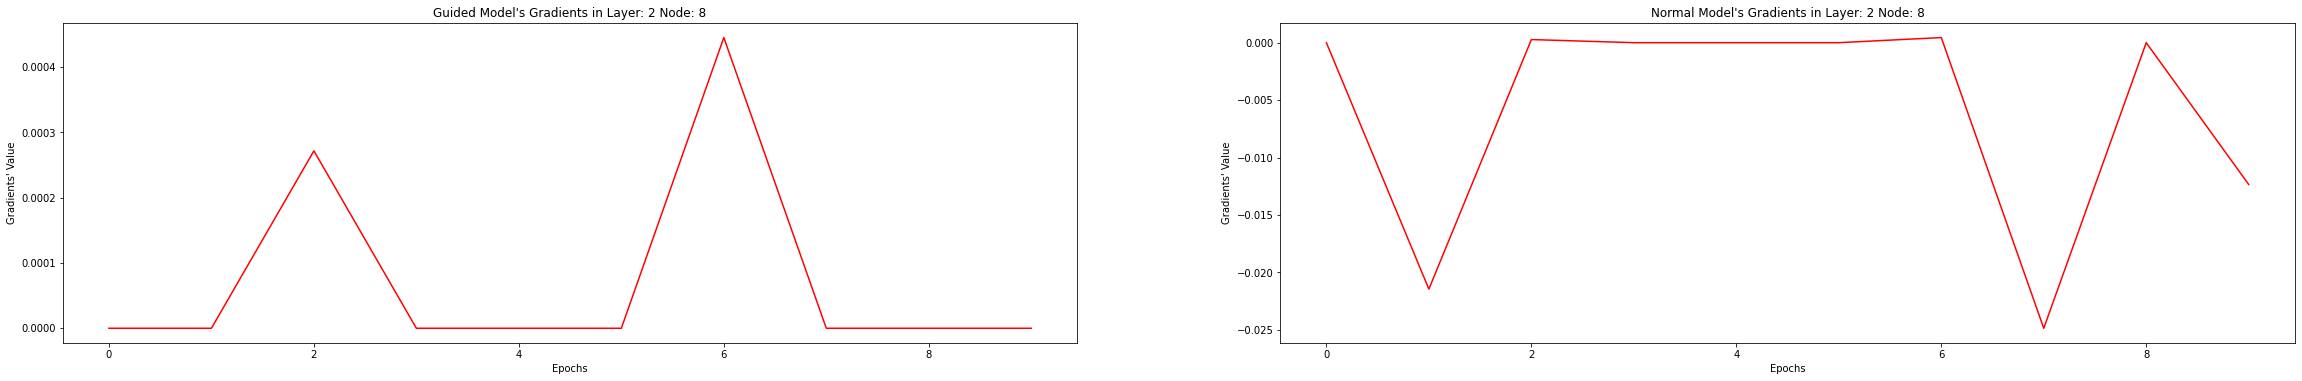

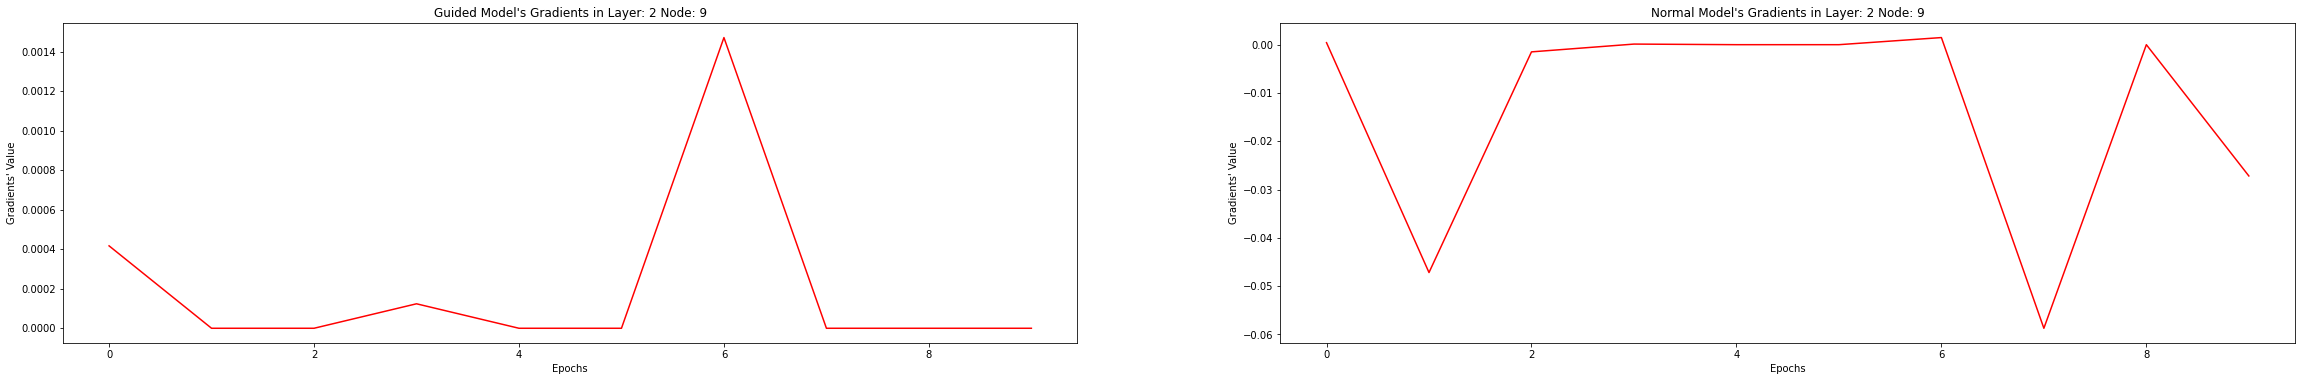

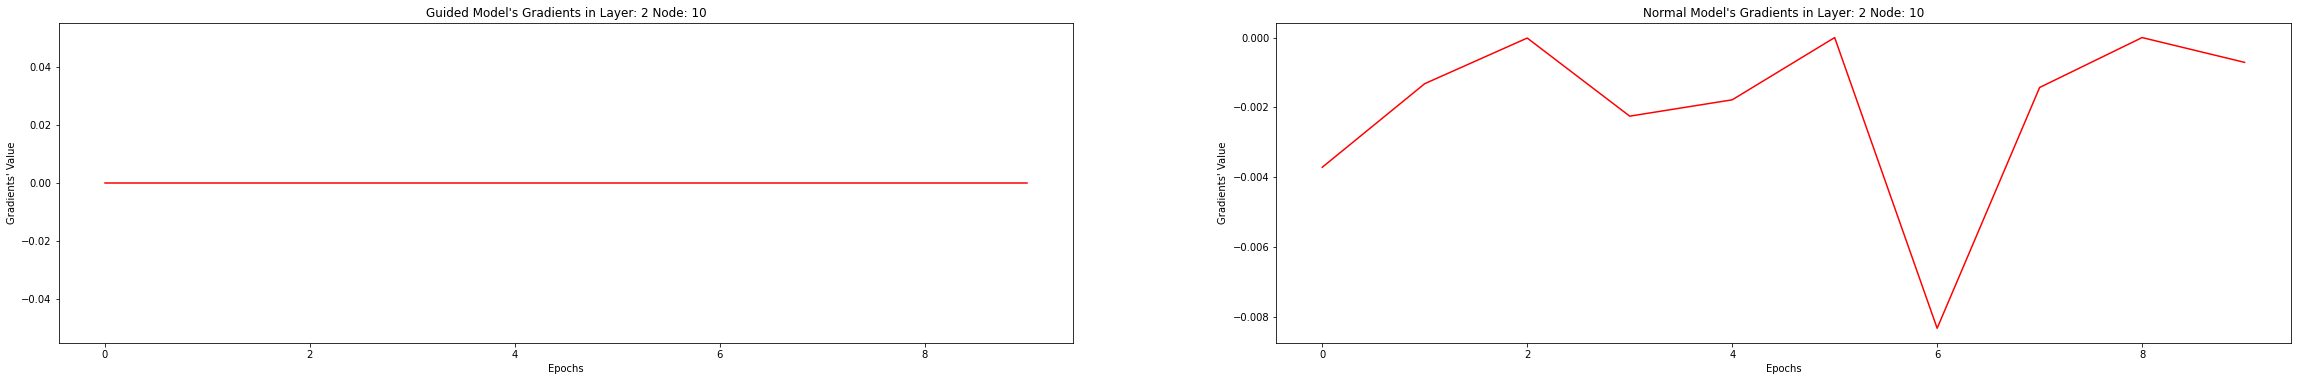

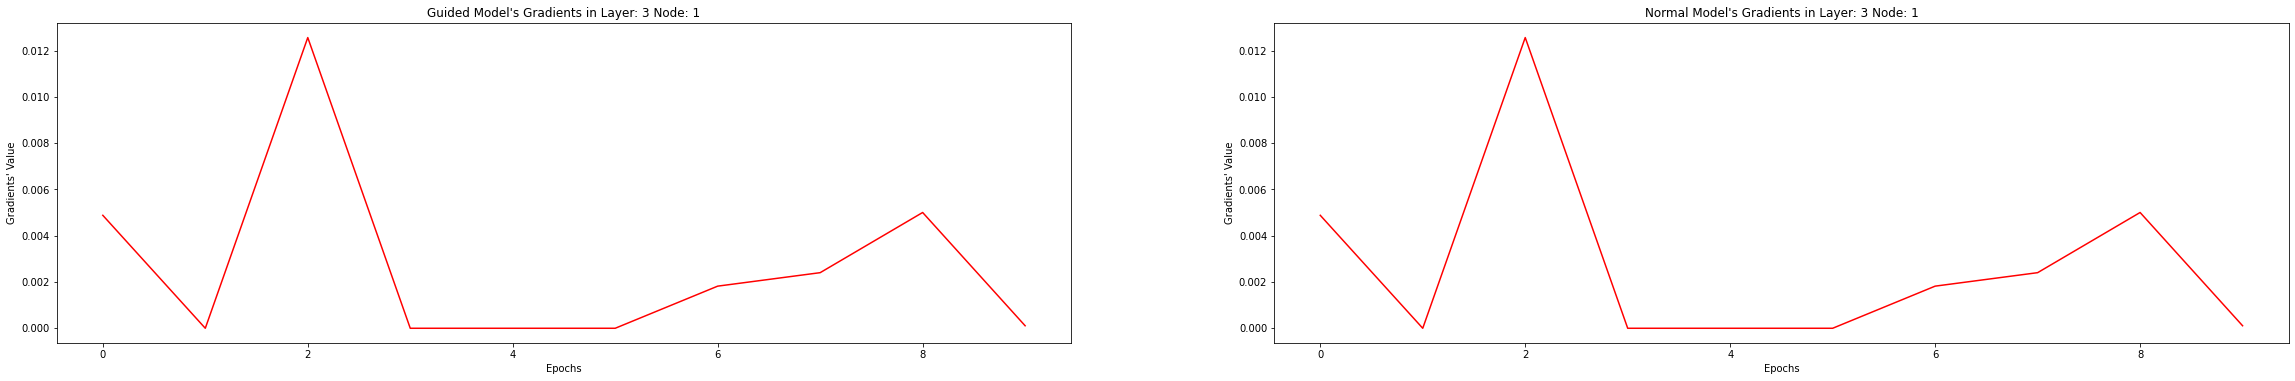

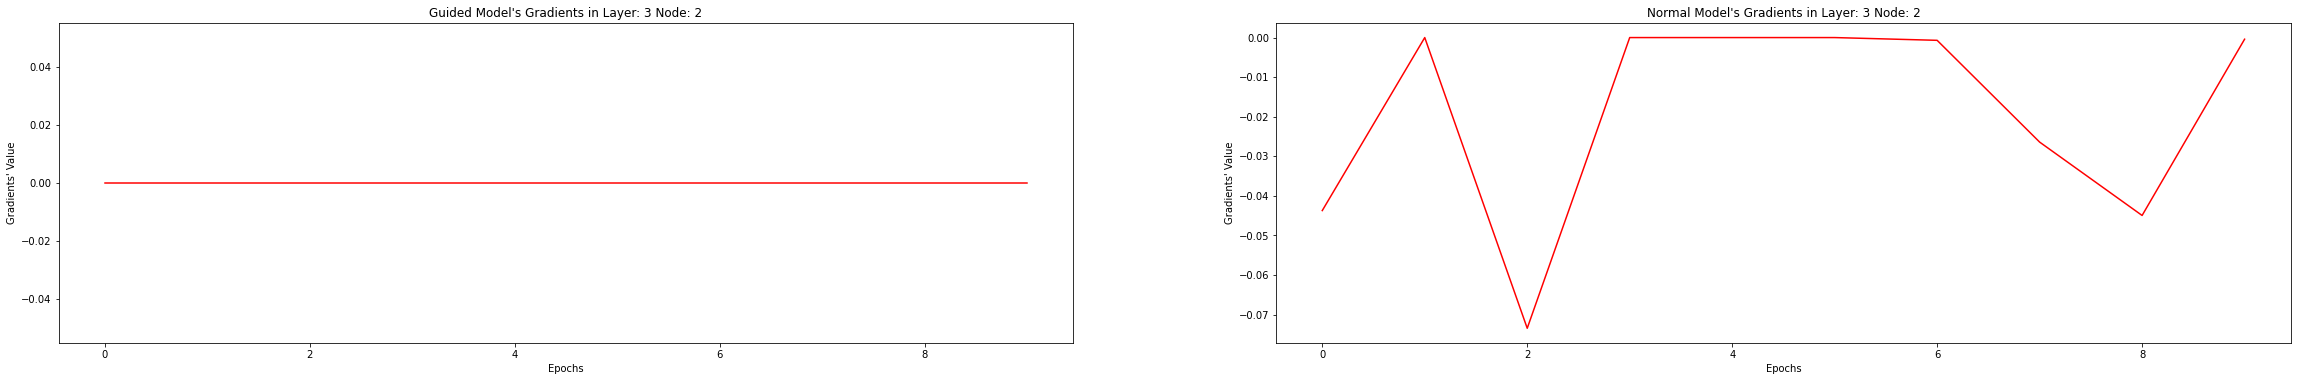

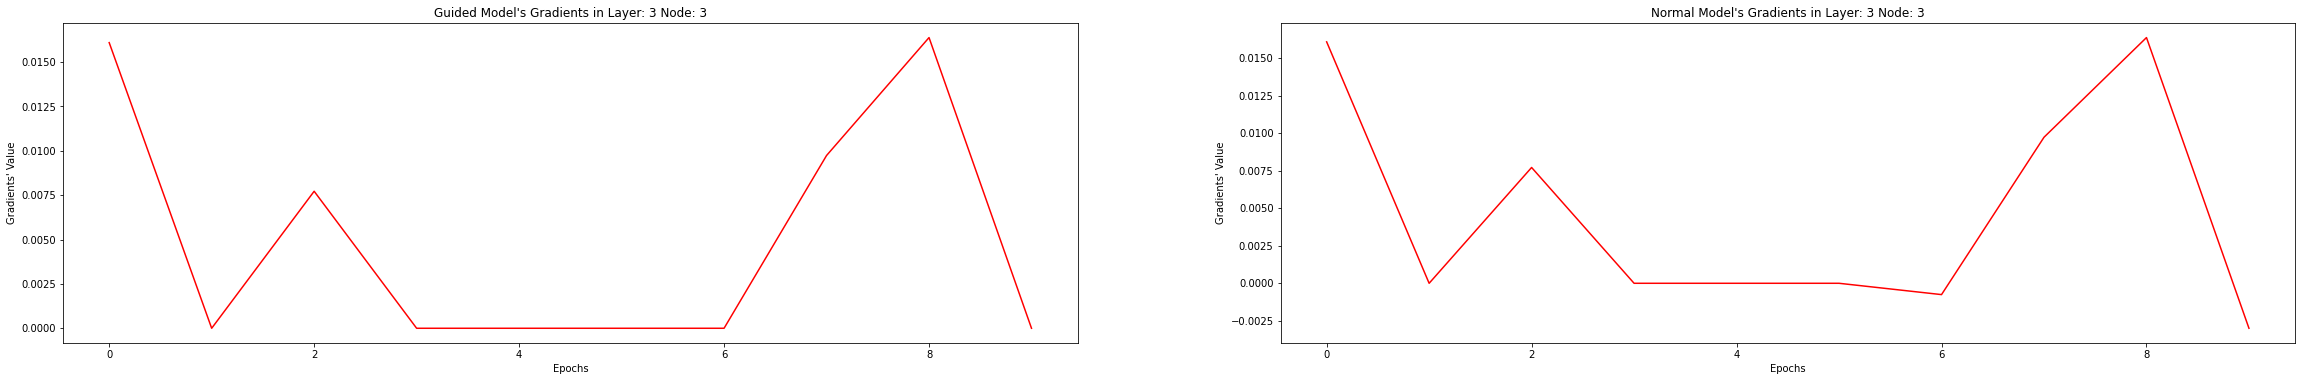

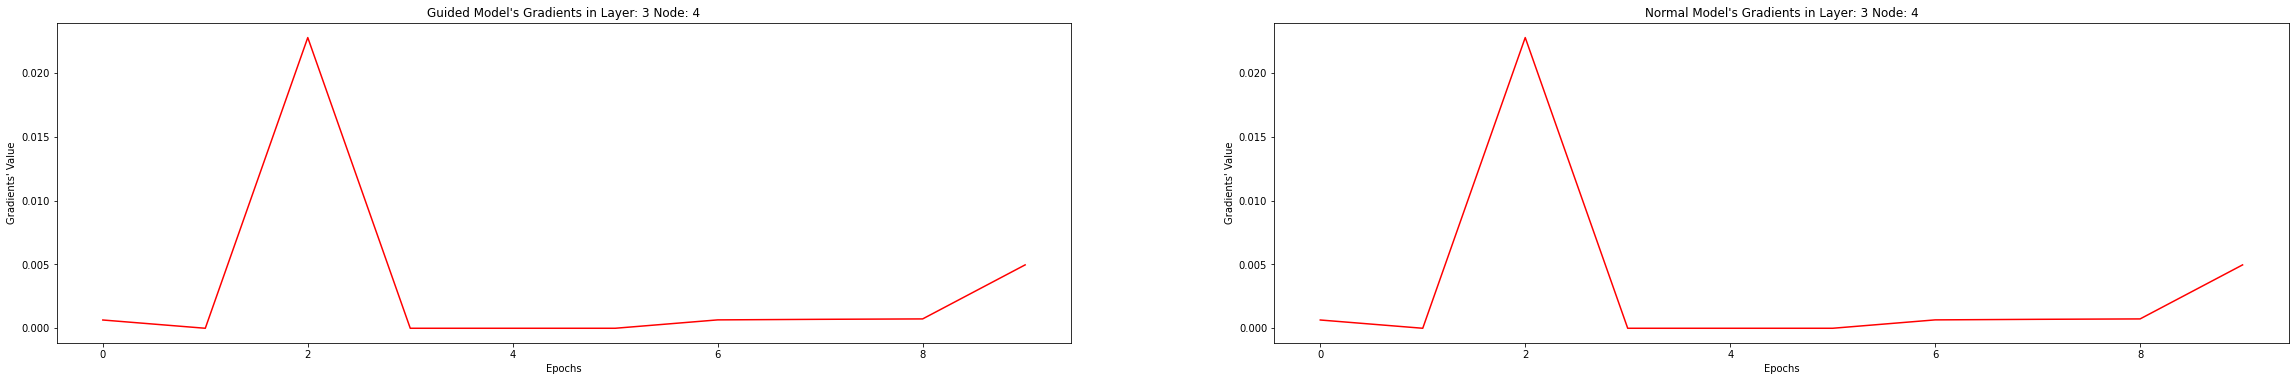

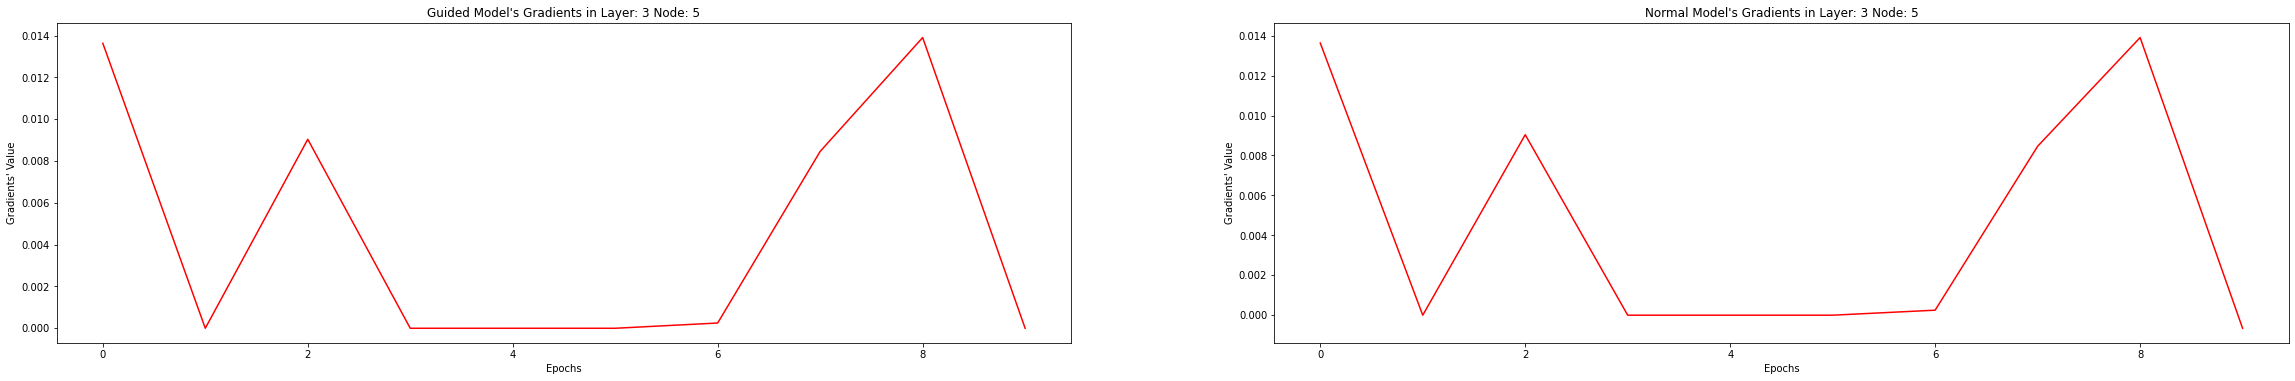

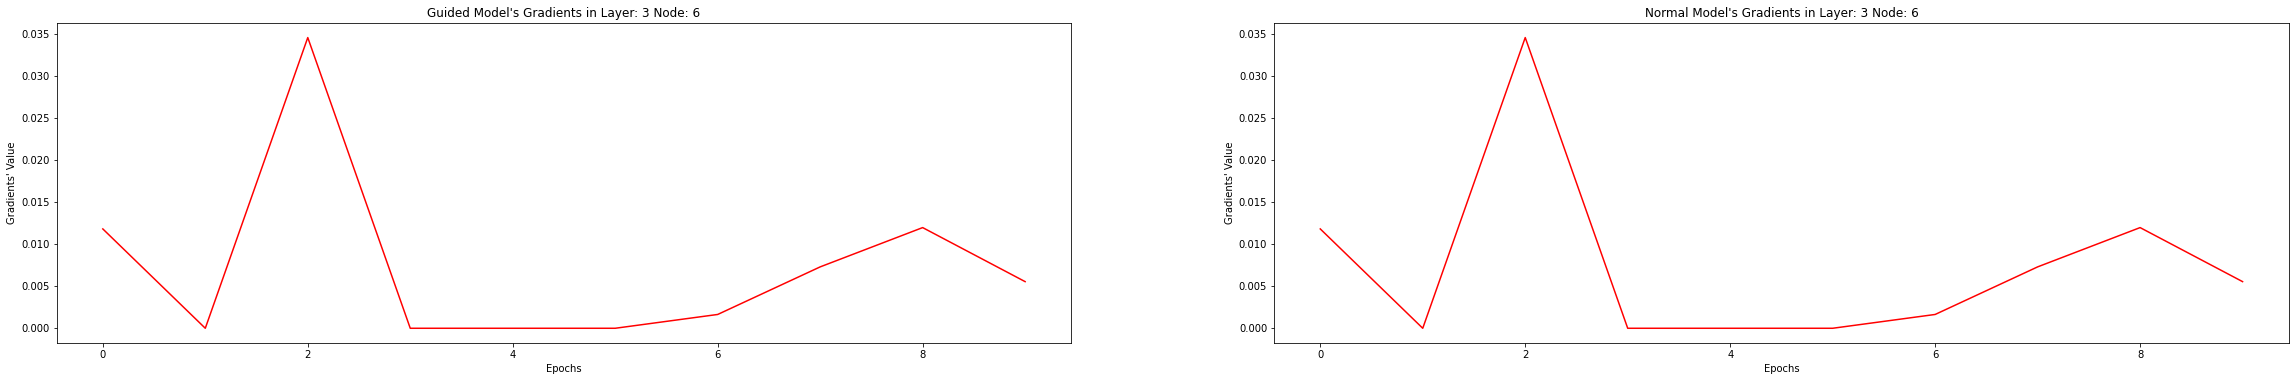

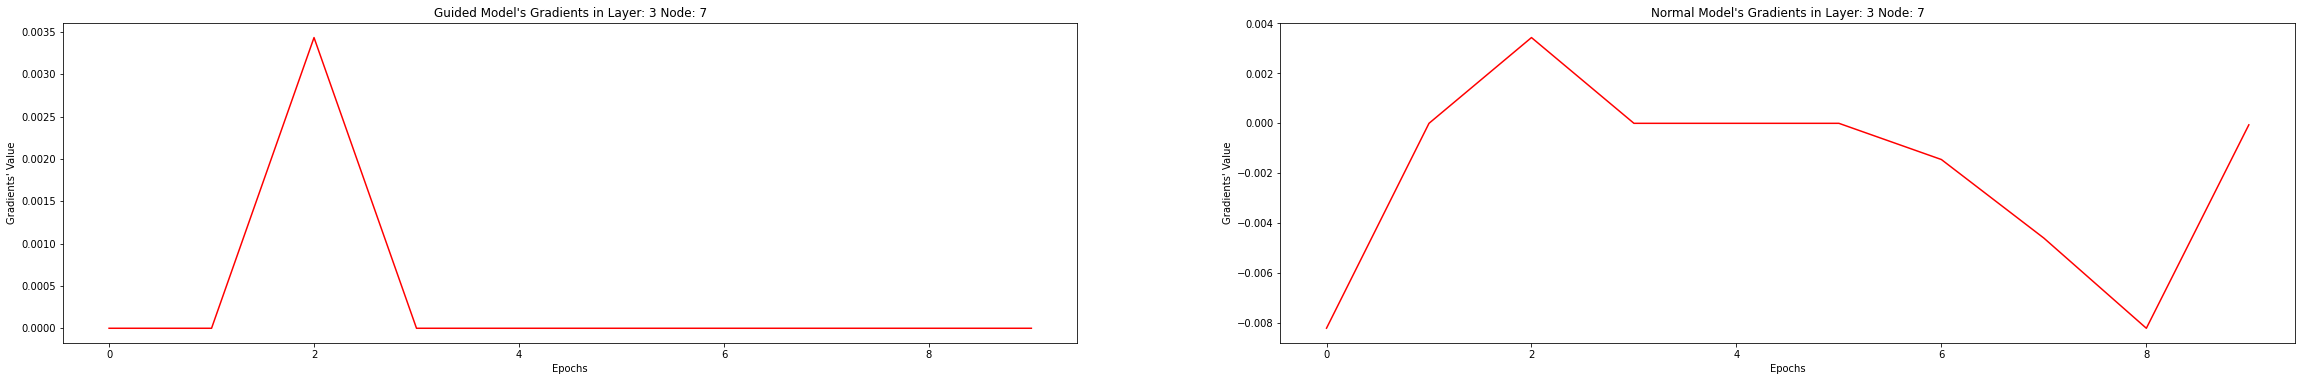

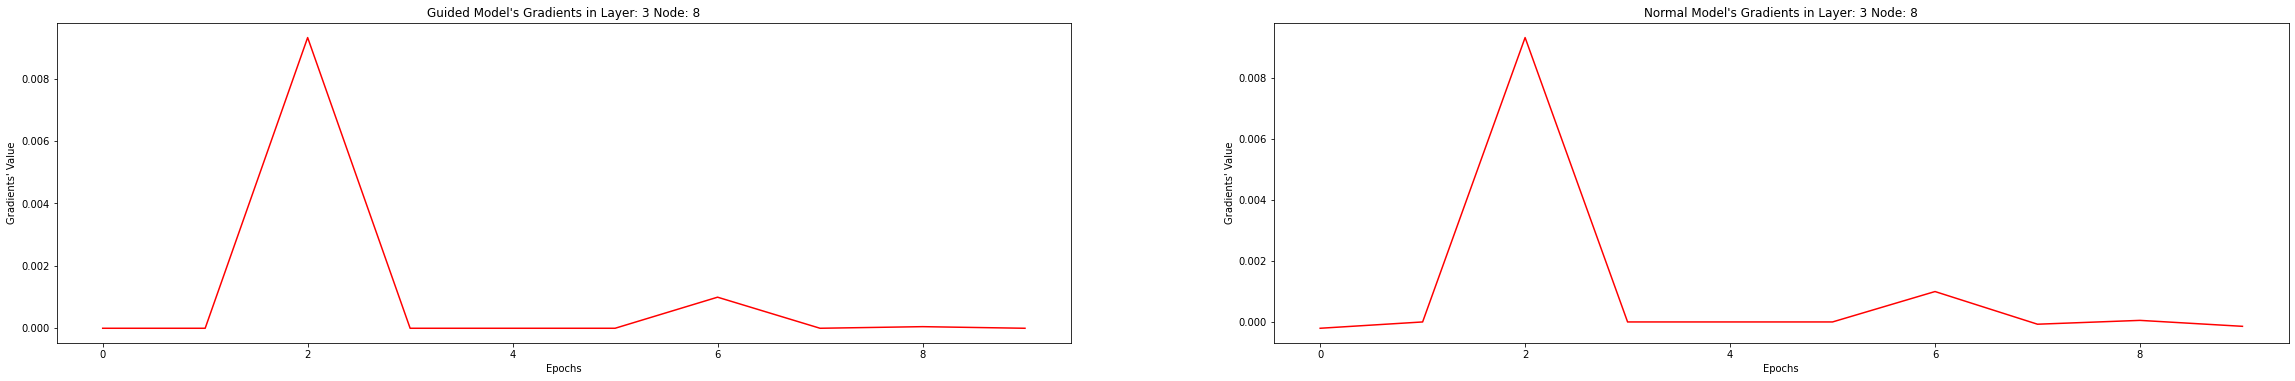

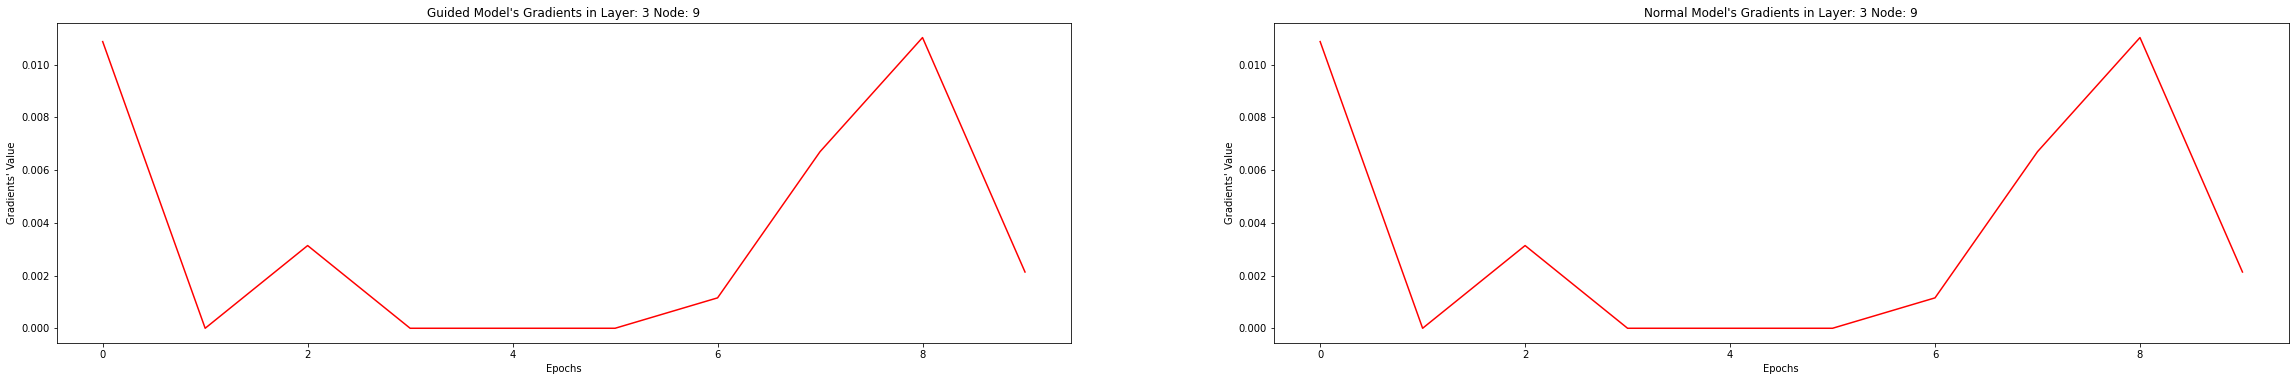

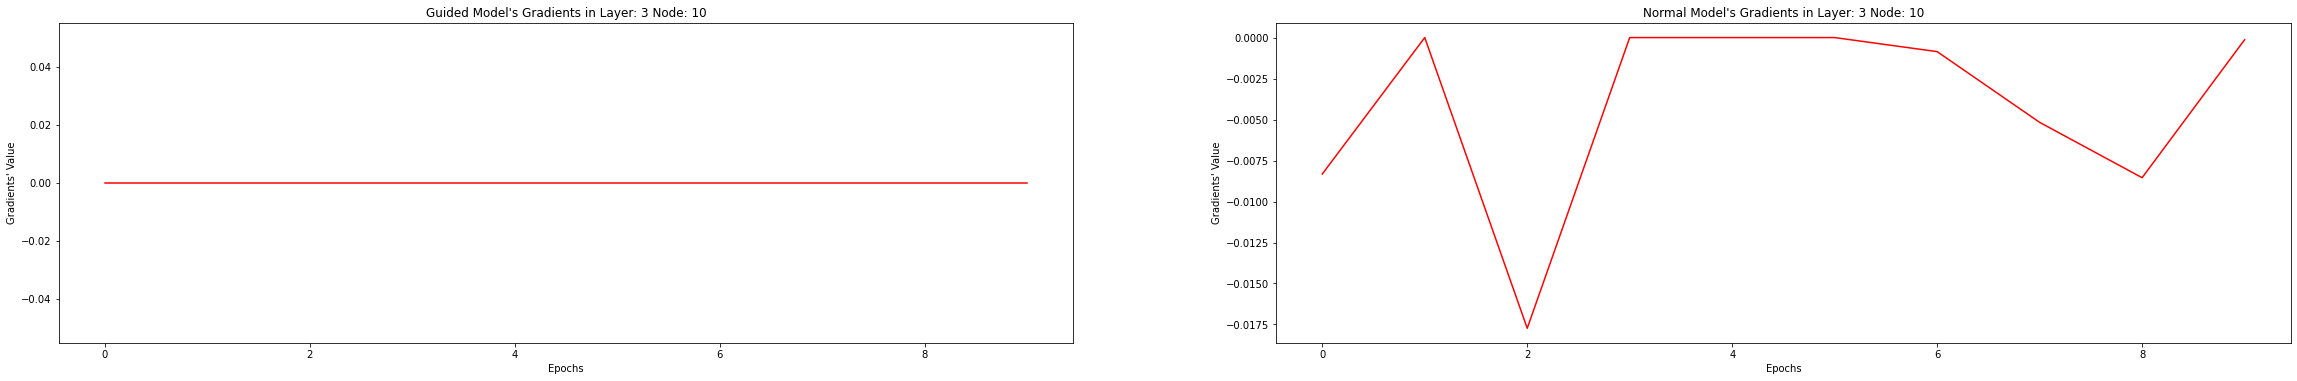

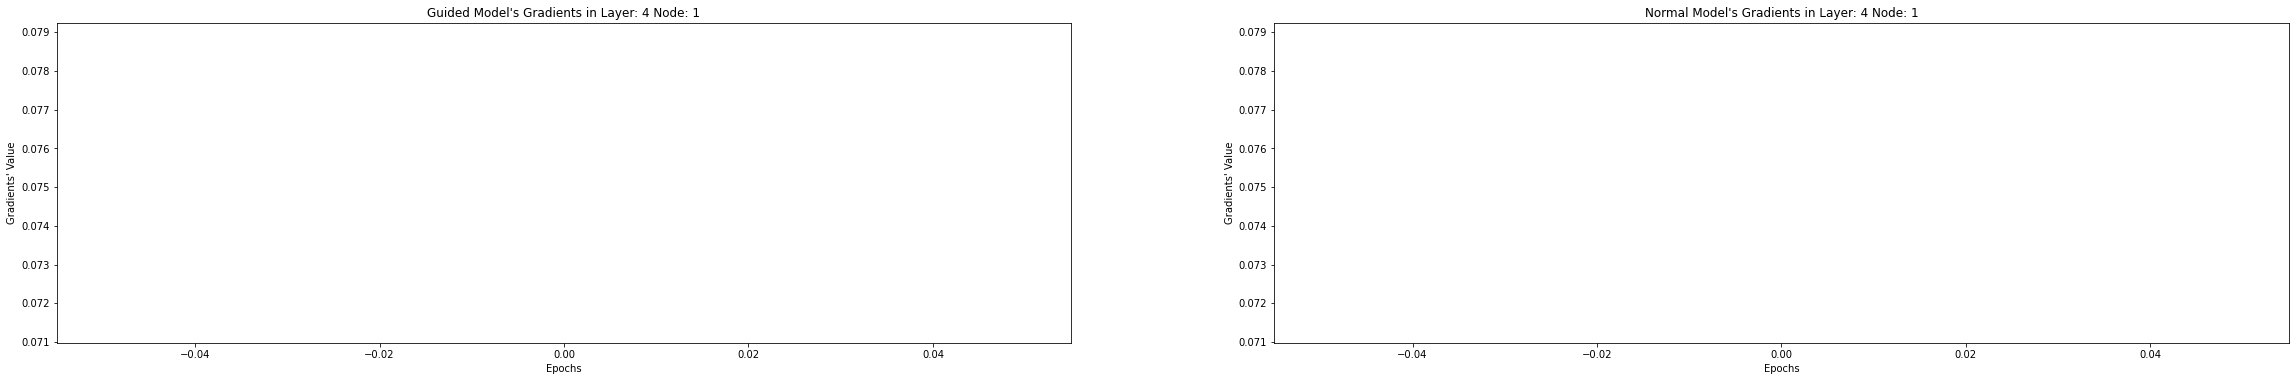

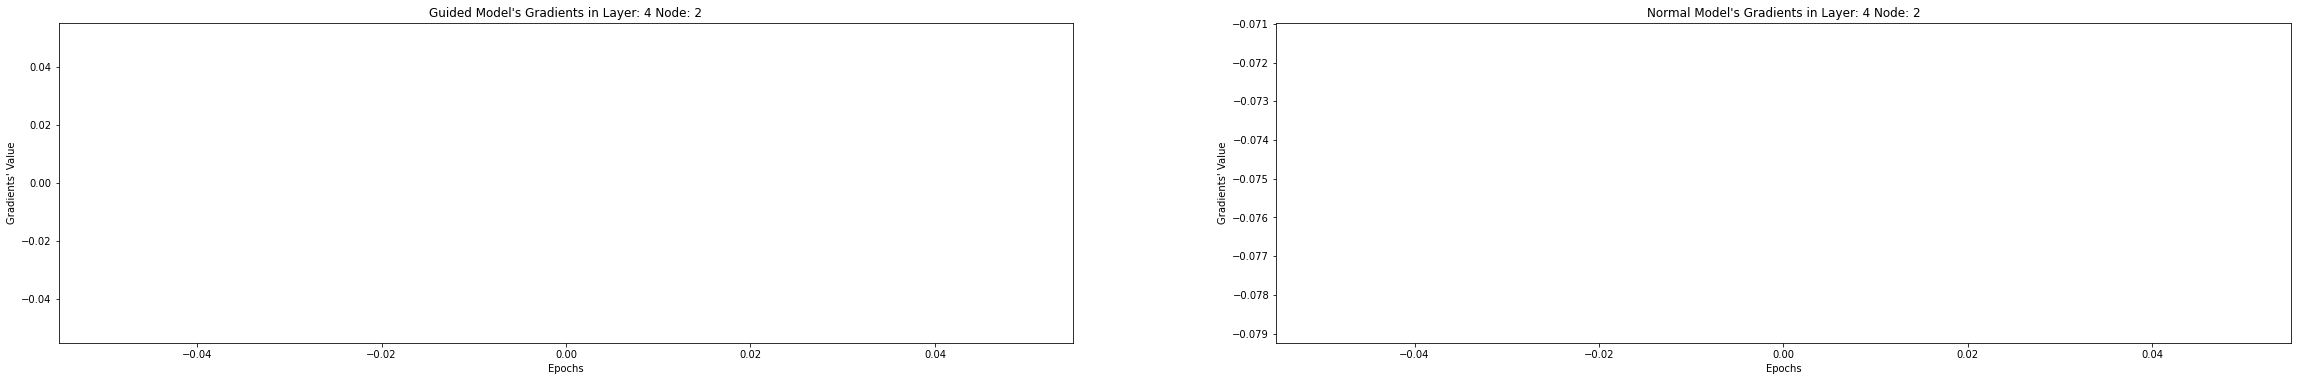

In [ ]:
guided_model_gradients_of_hidden_nodes(holder_of_new_gradients, holder_of_old_gradients, EPOCHS)

In [ ]:
print(GuidedBP_model_GCN.conv1)
sd = GuidedBP_model_GCN.state_dict()
print(sd.keys())
whole_weights = sd.items()
#print(whole_weights)

GCNConv(7, 10)
odict_keys(['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight', 'conv3.bias', 'conv3.lin.weight', 'lin.weight', 'lin.bias'])


In [ ]:
'''def train_step():
  before_guidance = []
  after_guidance = []
  GuidedBP_loss_batch = []
  non_GuidedBP_loss_batch = []


  GuidedBP_model_GCN.train()
  GuidedBP_optimizer.zero_grad()
  for batched_data in train_loader:
    GuidedBP_out = GuidedBP_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    GuidedBP_loss = loss_calculations(GuidedBP_out, batched_data.y)
    GuidedBP_loss_batch.append(GuidedBP_loss)
    GuidedBP_loss.backward()
    GuidedBP_optimizer.step()

    batched_before_guidance = []
    batched_after_guidance = []

    for name, param in GuidedBP_model_GCN.named_parameters():

      if name == "conv1.bias":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())
      if name == "conv1.lin.weight":
        #print(param.grad.detach().clone())
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())

      if name == "conv2.bias":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())
      if name == "conv2.lin.weight":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())

      if name == "conv3.bias":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())
      if name == "conv3.lin.weight":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())

      if name == "lin.bias":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())
      if name == "lin.weight":
        batched_before_guidance.append(param.grad.detach().clone())
        param.grad = np.maximum(np.zeros_like(param.grad), param.grad)
        batched_after_guidance.append(param.grad.detach().clone())
        
    before_guidance.append(batched_before_guidance)
    after_guidance.append(batched_after_guidance)
  #print(len(before_guidance[-1]))
    
  non_GuidedBP_backpropagation_SAME_MODEL(before_guidance)  
  GuidedBP_backpropagation_SAME_MODEL(after_guidance)

  GuidedBP_optimizer.step()
  
  #############################################################



  return torch.mean(torch.tensor(GuidedBP_loss_batch)), torch.mean(torch.tensor(non_GuidedBP_loss_batch))
'''

## **Gradients of Test Samples with respect to each class**

In [20]:
def compute_grad(model, graph, with_respect):
  prediction = model(graph.x, graph.edge_index, graph.batch)
  if with_respect == 1 :
    loss = loss_calculations(prediction, graph.y)
    #print(loss)
  elif with_respect == 2:
    loss = loss_calculations(prediction, torch.tensor([0]))
    #print(loss)  
  elif with_respect == 3:
    loss = loss_calculations(prediction, torch.tensor([1]))
    #print(loss)
  return torch.autograd.grad(loss, list(model.parameters()))

In [21]:
def compute_sample_grads(model, test_dataset, with_respect):

  sample_grads = [compute_grad(model, graph, with_respect) for graph in test_dataset]
  sample_grads = zip(*sample_grads)
  sample_grads = [torch.stack(shards) for shards in sample_grads]
  return sample_grads

In [22]:
a = torch.randn((2,7))
print(a)
b = torch.zeros_like(a)
print(b)
c = torch.maximum(a, b)
print(c)

tensor([[ 0.6490, -0.5420,  1.2377, -0.8318, -0.5183, -0.8079, -0.0586],
        [ 1.6957, -0.6417, -2.1617,  0.5090, -0.0081,  0.3498,  1.6141]])
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])
tensor([[0.6490, 0.0000, 1.2377, 0.0000, 0.0000, 0.0000, 0.0000],
        [1.6957, 0.0000, 0.0000, 0.5090, 0.0000, 0.3498, 1.6141]])


In [23]:
def compute_guided_gradients(your_model, dataset):
  per_sample_grads_wrt_graph_label = compute_sample_grads(your_model, dataset, 1)
  per_sample_grads_wrt_class_zero = compute_sample_grads(your_model, dataset, 2)
  per_sample_grads_wrt_class_one = compute_sample_grads(your_model, dataset, 3)

  grads_wrt_graph_label = per_sample_grads_wrt_graph_label[1].detach().tolist()
  guided_grads_wrt_graph_label = torch.maximum(torch.zeros_like(per_sample_grads_wrt_graph_label[1]), per_sample_grads_wrt_graph_label[1])
  guided_grads_wrt_graph_label = guided_grads_wrt_graph_label.detach().tolist()

  grads_wrt_class_zero = per_sample_grads_wrt_class_zero[1].detach().tolist()
  guided_grads_wrt_class_zero = torch.maximum(torch.zeros_like(per_sample_grads_wrt_class_zero[1]), per_sample_grads_wrt_class_zero[1])
  guided_grads_wrt_class_zero = guided_grads_wrt_class_zero.detach().tolist()

  grads_wrt_class_one = per_sample_grads_wrt_class_one[1].detach().tolist()
  guided_grads_wrt_class_one = torch.maximum(torch.zeros_like(per_sample_grads_wrt_class_one[1]), per_sample_grads_wrt_class_one[1])
  guided_grads_wrt_class_one = guided_grads_wrt_class_one.detach().tolist()

  return guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one

In [24]:
guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one = compute_guided_gradients(GuidedBP_model_GCN, test_dataset)

## **Fidelity**

In [25]:

def Compute_ROC_AUC(your_model, your_dataset):
  preds = []
  reals = []
  #print(len(your_dataset))
  num_classes = 2
  
  if num_classes > 2:
    print("Fidelity is only for Binaryclassification")
    return 0
    
  your_model.eval()
  for batched_data in your_dataset:
    GuidedBP_test_out = your_model(batched_data.x, batched_data.edge_index, batched_data.batch)
    logits = F.log_softmax(GuidedBP_test_out, dim=1)
    prob = F.softmax(logits, dim=1)
    
    preds.append(prob.cpu().detach())
    
  for i in range(len(your_dataset)):
    reals.append(your_dataset[i].y.cpu().detach().tolist())  
  preds = torch.cat(preds).cpu().numpy()
  preds = preds[:, 1]

  
  roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
  return roc_auc
  
  #return preds, reals

In [26]:
def saliency(dataset, gradients):
  Final= []
  for i in range(len(dataset)):
    Mid = []
    for node in dataset[i].x.detach().numpy():
      First = []
      for grad_list in gradients[i]:
        First.append(np.multiply(node, grad_list))
      Mid.append(First)
    Final.append(Mid)
  
  Saliency_Nodes = []
  for graph in Final:
    Node = []
    for node in graph:
      Grad = []
      for grad in node:
        Grad.append(sum(grad))
      Node.append(sum(Grad))
    #norm = [(float(i)-min(Node))/(max(Node)-min(Node)) for i in Node]
    norm = [(float(i))/(max(Node) + 1e-16) for i in Node]
    Saliency_Nodes.append(norm)
  return Saliency_Nodes

In [27]:
def is_salient(score, importance_range):
	start, end = importance_range
	if start <= score <= end:
		return True
	else:
		return False

In [28]:
def drop_important_nodes(your_dataset, importance_range, grads_first_layer):
  GuidedBP_attribution_scores = saliency(your_dataset, grads_first_layer)
  occluded_GNNgraph_list = []
  
  for i in range(len(GuidedBP_attribution_scores)):
    sample_graph = deepcopy(your_dataset[i])
    for j in range(len(sample_graph.x)):
      
      if is_salient((GuidedBP_attribution_scores[i][j]), importance_range):
        #print("before: ", sample_graph.x[j])
        sample_graph.x[j][:] = 0
        #print(torch.zeros_like(sample_graph.x[j]))
        #print("manipulated: ",sample_graph.x[j])
    occluded_GNNgraph_list.append(sample_graph)
  return occluded_GNNgraph_list

In [29]:
def Fidelity(your_model, your_dataset, grads_first_layer, importance_range):

  auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
  new_graph_dataset = drop_important_nodes(your_dataset, importance_range, grads_first_layer)
  auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

  return auc_roc_after_droping_important_nodes - auc_roc_before_droping_important_nodes

## **Contrastivity**

In [30]:
def binarize_scores(your_dataset, grads_first_layer, importance_range):
  GuidedBP_attribution_scores = saliency(your_dataset, grads_first_layer)
  binarized_attribution_scores_list = []
  for scores in GuidedBP_attribution_scores:
    binary_score = ''
    for score in scores:
      if is_salient(abs(float(score)), importance_range):
        binary_score += '1'
      else:
        binary_score += '0'
    binarized_attribution_scores_list.append(binary_score)
  return binarized_attribution_scores_list

In [31]:
def compute_contrastivity(your_dataset, your_grads_class0, your_grads_class1, importance_range):
  binarized_salient_nodes_for_class0 = binarize_scores(your_dataset, your_grads_class0, importance_range)
  binarized_salient_nodes_for_class1 = binarize_scores(your_dataset, your_grads_class1, importance_range)

  result_list = []
	# Calculate hamming distance
  for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
    assert len(class_0) == len(class_1)
    d = hamming(class_0, class_1)
    result_list.append(d / len(class_0))
    
  return sum(result_list) / len(result_list)


## **Sparsity**

In [32]:
def binarize_nodes(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range):
  Guided_attribution_scores_class0 = saliency(your_dataset, your_grads_class0)
  Guided_attribution_scores_class1 = saliency(your_dataset, your_grads_class1)
  Guided_attribution_scores_graph = saliency(your_dataset, your_grads_graph)

  class_0_salient_nodes = []
  class_1_salient_nodes = []
  salient_nodes_graph = []
  
  for i in range(len(Guided_attribution_scores_class0)):
      class_0_graph = []
      for j in range(len(Guided_attribution_scores_class0[i])):
        if is_salient((Guided_attribution_scores_class0[i][j]), importance_range):
          class_0_graph.append(1)
        else:
          class_0_graph.append(0)
      class_0_salient_nodes.append(class_0_graph)

  for i in range(len(Guided_attribution_scores_class1)):
      class_1_graph = []
      for j in range(len(Guided_attribution_scores_class1[i])):
        if is_salient((Guided_attribution_scores_class1[i][j]), importance_range):
          class_1_graph.append(1)
        else:
          class_1_graph.append(0)
      class_1_salient_nodes.append(class_1_graph)

  for i in range(len(Guided_attribution_scores_graph)):
      class_graph = []
      for j in range(len(Guided_attribution_scores_graph[i])):
        if is_salient((Guided_attribution_scores_graph[i][j]), importance_range):
          class_graph.append(1)
        else:
          class_graph.append(0)
      salient_nodes_graph.append(class_graph)

  return salient_nodes_graph, class_0_salient_nodes, class_1_salient_nodes

In [33]:
def count_important_nodes(salient_list):
  return sum(salient_list)

In [34]:
def compute_sparsity(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range):
  salient_nodes_graph, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(your_dataset, your_grads_graph, your_grads_class0, your_grads_class1, importance_range)
  #print(salient_nodes_graph)
  #print(class_0_salient_nodes)
  #print(class_1_salient_nodes)
  sparsity_list = []
  for i in range(len(salient_nodes_graph)):
    d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
    d = d / (len(salient_nodes_graph) * 2)
    sparsity_list.append(1 - d)
  return sum(sparsity_list) / len(sparsity_list)

## **Get Metrics**

In [35]:
def go_to_evaluations(your_model, dataset, importance_range):
  start_generation = perf_counter()
  guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one = compute_guided_gradients(your_model, dataset)
  time_consumption = perf_counter() - start_generation

  fid_guided_glabel = Fidelity(your_model, dataset, guided_grads_wrt_graph_label, importance_range)

  contrastivity_with_guided = compute_contrastivity(dataset, guided_grads_wrt_class_zero, guided_grads_wrt_class_one, importance_range)

  sparsity_with_guided = compute_sparsity(dataset, guided_grads_wrt_graph_label, guided_grads_wrt_class_zero, guided_grads_wrt_class_one, importance_range)


  #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
  with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow([str(Explainability_name), "MUTAG", fid_guided_glabel, contrastivity_with_guided, sparsity_with_guided, time_consumption])

  #return fid_square_glabel, contrastivity_with_square, sparsity_with_square, time_consumption

In [36]:
go_to_evaluations(GuidedBP_model_GCN, test_dataset, (0.5, 1))